# Handling missing values

1. [Packages](#packages)
2. [Loading data](#loding-data)
3. [Target variable](#Target_variable)
3. [Handling missing values](#handling-missing-values)

The main data cleansing done in this notebook is : 
- Replaced all 0 values with nan values
- Droped all null columns (% of missing vlaues > 99%)
- Droped all null rows (% of missing vlaues > 99%)
- Fill out all remaining values with 0

Packages 

In [99]:
import os
#Change current directory
os.chdir ('/home/hamza_hajjini@MCC.DOMAIN/bcppmchurn')
#Check the current directory
os.getcwd()

'/home/hamza_hajjini@MCC.DOMAIN/bcppmchurn'

In [100]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
from scipy import stats
from pyspark.sql import SparkSession
from pyspark.sql import functions
import yaml 

from sklearn.model_selection import train_test_split 

from src.components.data_ingestion import get_feature_tables_from_impala, get_churn_target 
from src.components.data_structuring import structuringPipeline
from src.eda import utils
from src.eda.utils import columnsFamilies

In [101]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"

In [102]:
#Reload modules in case a change has occured
#import importlib
#from src.components import data_ingestion, data_structuring
#importlib.reload(data_ingestion)
#importlib.reload(data_structuring)

### Loding data

--------------------

In [157]:
#Loading data. Ensure that dn is a str 
data_date = "2024-10-11"
df_train = pd.read_csv(f"{train_dev_test_path}/{data_date}_df_train.csv", index_col = 0, dtype= {"dn": "string"}) 
df_dev = pd.read_csv(f"{train_dev_test_path}/{data_date}_df_dev.csv", index_col = 0, dtype= {"dn": "string"})
df_test = pd.read_csv(f"{train_dev_test_path}/{data_date}_df_test.csv", index_col = 0, dtype= {"dn": "string"})

In [158]:
#Quick check
print (f"df_train shape :{df_train.shape}")
print (f"df_dev shape: {df_dev.shape}")
print (f"df_test shape: {df_test.shape}")
print (f"Column dn's type: {df_train.dn.dtype}")

df_train shape :(150000, 3582)
df_dev shape: (25000, 3582)
df_test shape: (10000, 3582)
Column dn's type: string


--------------

### Target variable 

df_train target distribution


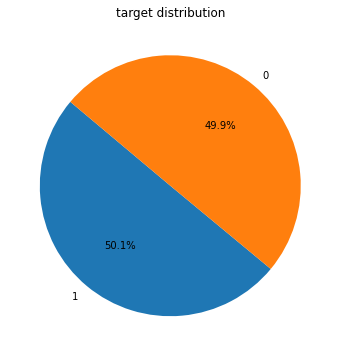

In [159]:
#Visualise target variable distribution 
print("df_train target distribution")
utils.vis_target_distribution(df_train["churn"])

df_dev target distribution


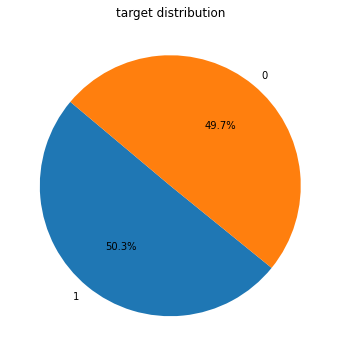

In [160]:
#Visualise target variable distribution 
print("df_dev target distribution")
utils.vis_target_distribution(df_dev["churn"])

df_test target distribution


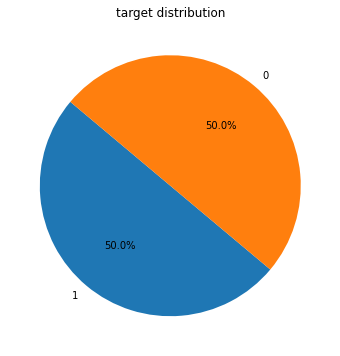

In [161]:
#Visualise target variable distribution 
print("df_test target distribution")
utils.vis_target_distribution(df_test["churn"])

### Handling missing values 

In [162]:
#Get numerical columns from df
df_numerical_columns = df_train.dtypes[df_train.dtypes != "object" ].index.to_list()
df_numerical_columns = [ column for column in df_numerical_columns if column not in ["dn", "dn_group_id", "churn" ]]

#### Replace all 0 values with nan value

**df_train**

In [163]:
print (f"Are there any 0 values in df_train : {(df_train[df_numerical_columns] == 0).any().any()} ")
df_train[df_numerical_columns] = df_train[df_numerical_columns].replace(0, np.nan)
print (f"Are still there any 0 values in df_train after transforming 0 values into nan : {(df_train[df_numerical_columns] == 0).any().any()} ")

Are there any 0 values in df_train : True 
Are still there any 0 values in df_train after transforming 0 values into nan : False 


**df_dev**

In [164]:
print (f"Are there any 0 values in df_train : {(df_dev[df_numerical_columns] == 0).any().any()} ")
df_dev[df_numerical_columns] = df_dev[df_numerical_columns].replace(0, np.nan)
print (f"Are still there any 0 values in df_train after transforming 0 values into nan : {(df_dev[df_numerical_columns] == 0).any().any()} ")

Are there any 0 values in df_train : True 
Are still there any 0 values in df_train after transforming 0 values into nan : False 


**df_test**

In [165]:
print (f"Are there any 0 values in df_train : {(df_test[df_numerical_columns] == 0).any().any()} ")
df_test[df_numerical_columns] = df_test[df_numerical_columns].replace(0, np.nan)
print (f"Are still there any 0 values in df_train after transforming 0 values into nan : {(df_test[df_numerical_columns] == 0).any().any()} ")

Are there any 0 values in df_train : True 
Are still there any 0 values in df_train after transforming 0 values into nan : False 


#### Drop all columns containing 100% of missing values

In [166]:
#Drop all null columns in df_train
df_train = utils.drop_df_null_columns(df_train, threshold = 99)

number of null columns in dataframe : 2490
DataFrame new shape (150000, 1092)


In [169]:
#Take same columns as df_train
df_dev = df_dev[df_train.columns]
df_test = df_test[df_train.columns]
print(f"df_dev shape : {df_dev.shape}")
print(f"df_test shape : {df_test.shape}")

df_dev shape : (25000, 1092)
df_test shape : (10000, 1092)


#### Drop all rows containing 100% of missing values 

In [170]:
#Drop all null rows of df_train
df_train_T = df_train.T
df_train_T=utils.drop_df_null_columns(df_train_T, threshold=99)
df_train = df_train_T.T
#Drop all null rows of df_train
df_dev_T = df_dev.T
df_dev_T=utils.drop_df_null_columns(df_dev_T, threshold=99)
df_dev = df_dev_T.T
#Drop all null rows of df_train
df_test_T = df_test.T
df_test_T=utils.drop_df_null_columns(df_test_T, threshold=99)
df_test = df_test_T.T

number of null columns in dataframe : 63008
DataFrame new shape (1092, 86992)
number of null columns in dataframe : 10437
DataFrame new shape (1092, 14563)
number of null columns in dataframe : 4161
DataFrame new shape (1092, 5839)


#### df_train missing values 

Decompose df on columns families, and handle missing values family by family

In [171]:
#Get columns families : 
colFam = columnsFamilies(df_train)
columns_families = colFam.get_columns_families()

Column family complaints_complaints_complaint_status_resolu_duration>


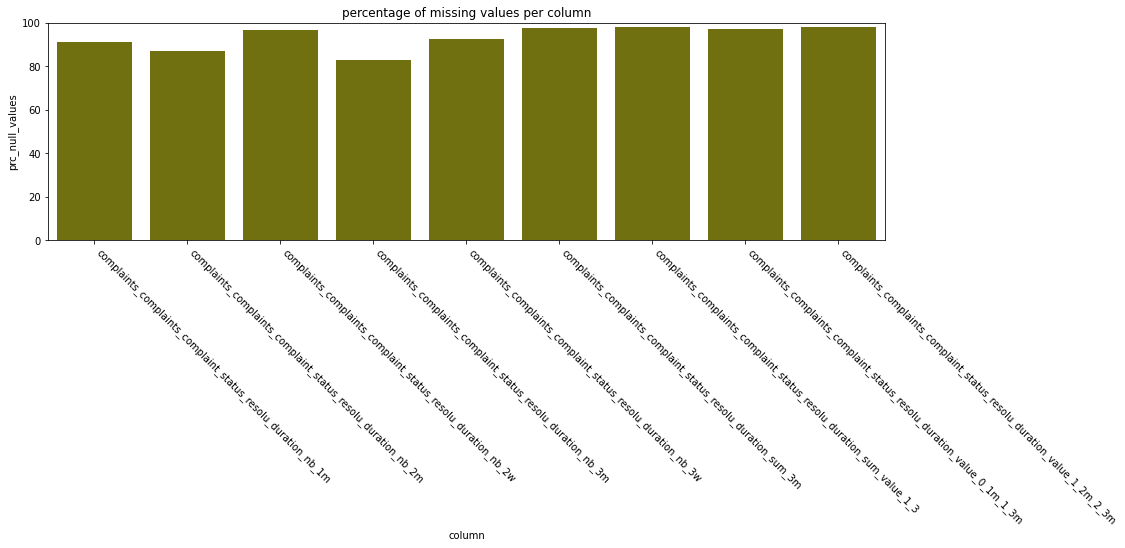

Column family complaints_complaints_complaint_status_resolu_total>


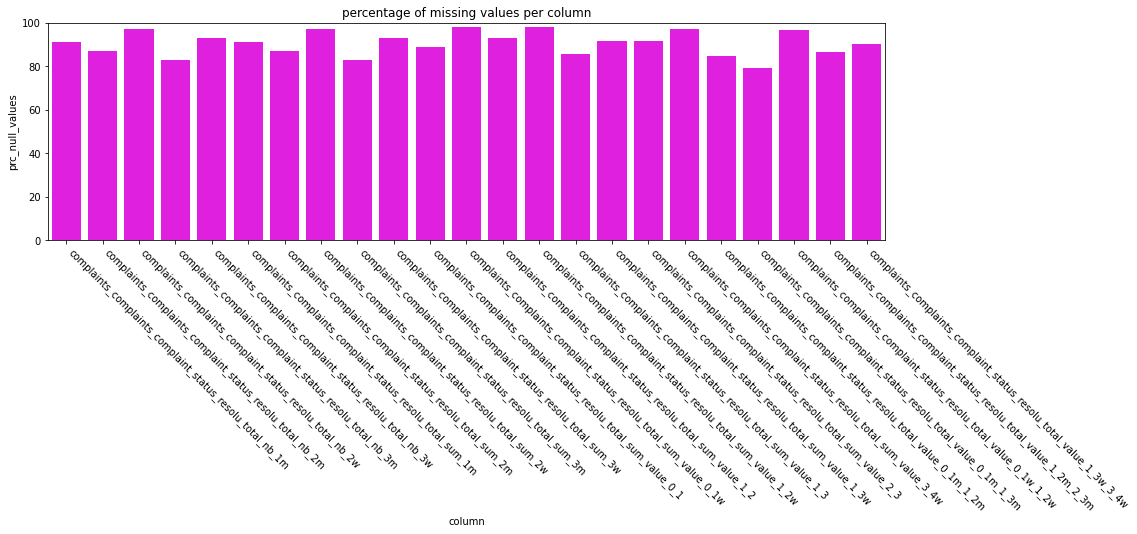

Column family complaints_complaints_complaint_type_modification_duration>


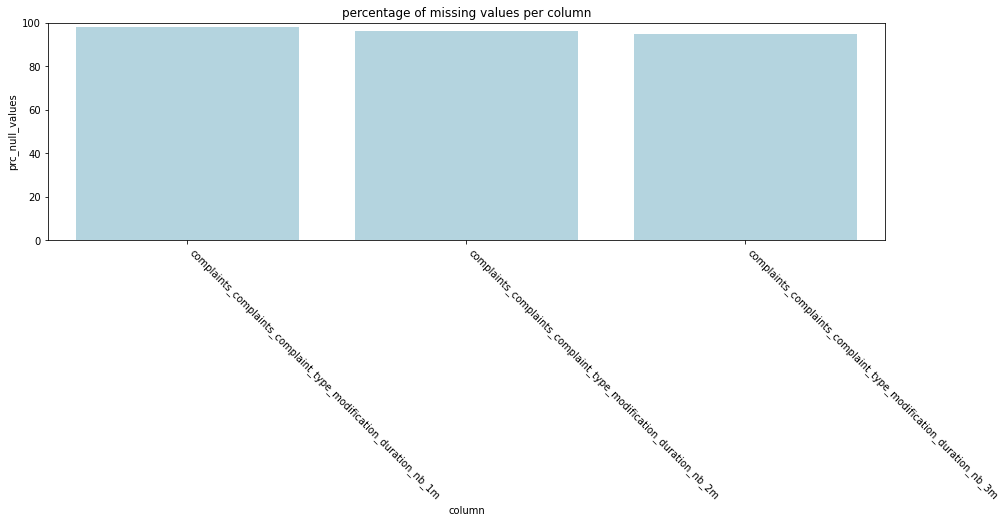

Column family complaints_complaints_complaint_type_modification_total>


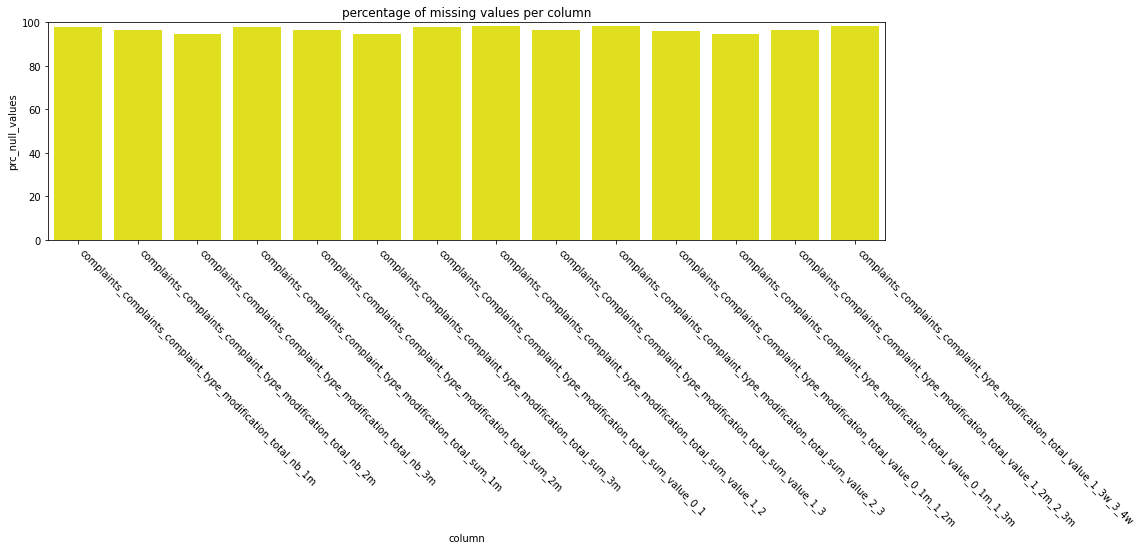

Column family complaints_complaints_complaint_type_reclamation_duration>


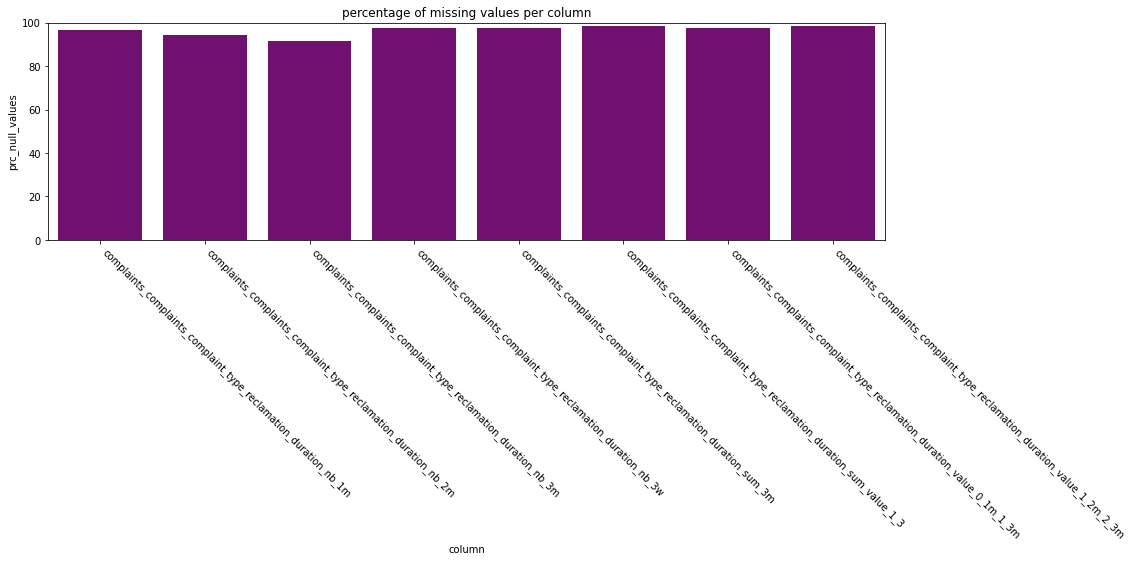

Column family complaints_complaints_complaint_type_reclamation_total>


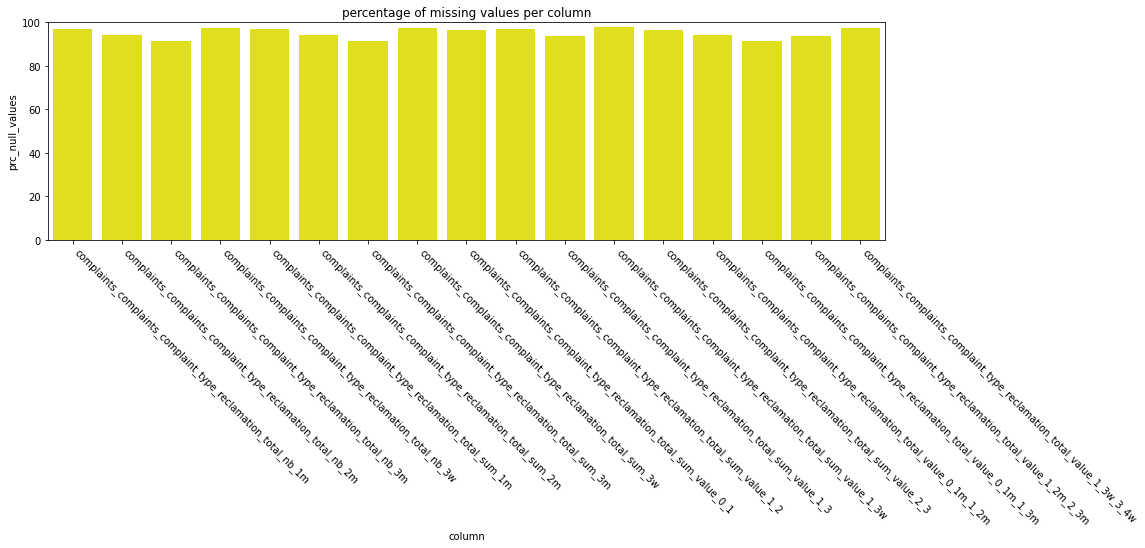

Column family complaints_complaints_complaint_type_retention_duration>


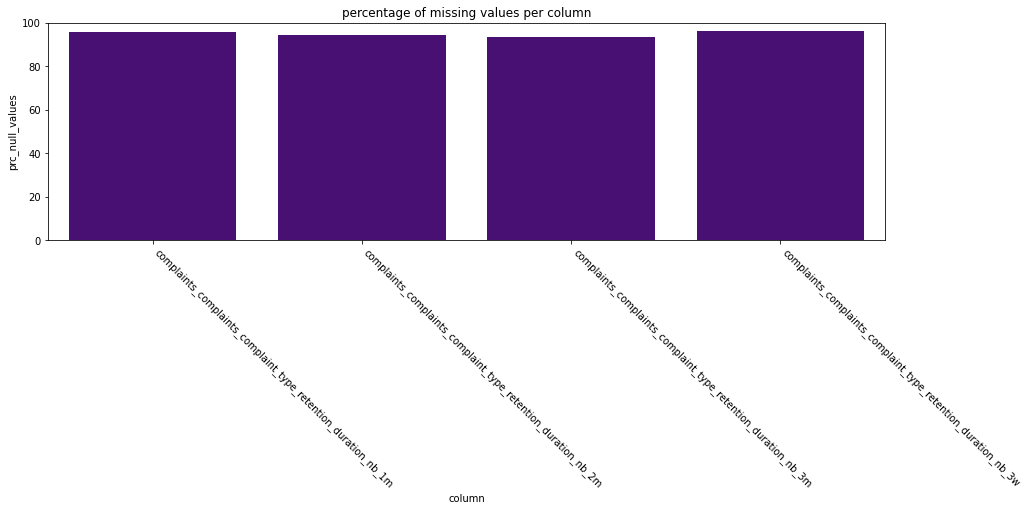

Column family complaints_complaints_complaint_type_retention_total>


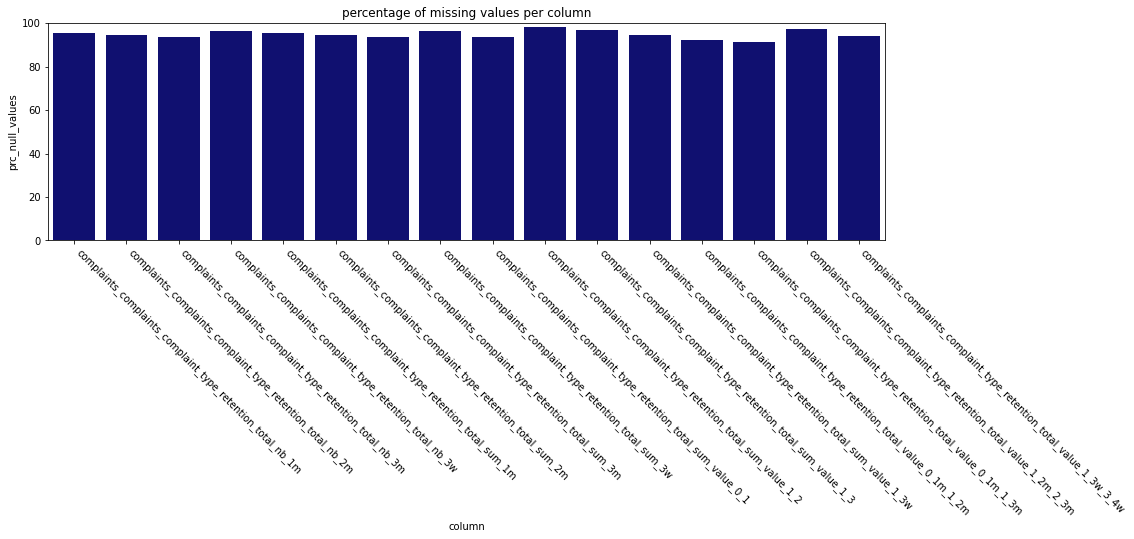

Column family complaints_complaints_weekend_n_duration>


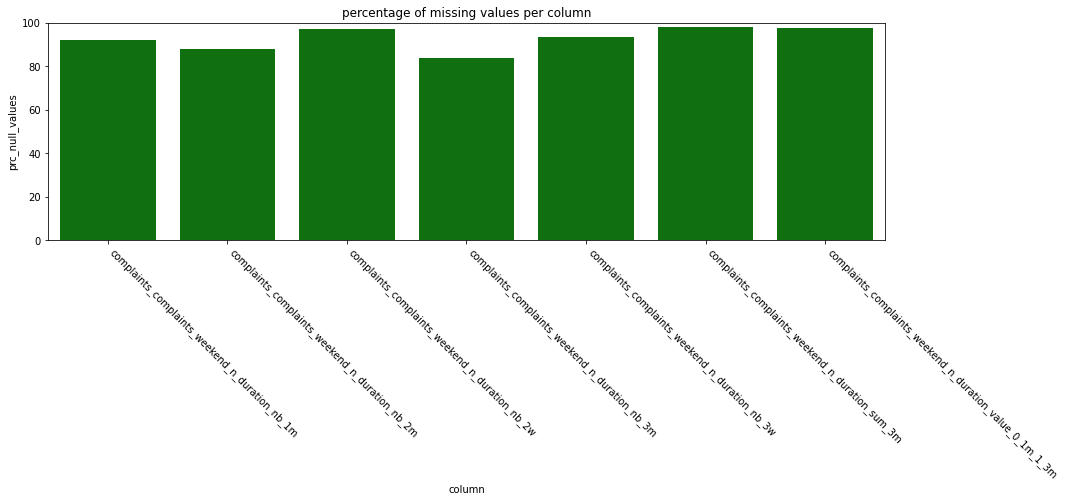

Column family complaints_complaints_weekend_n_total>


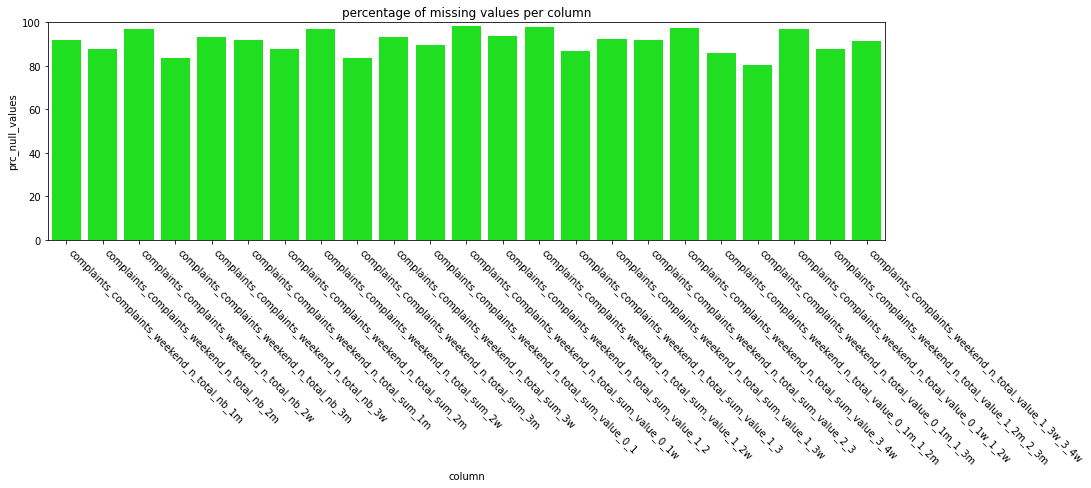

Column family complaints_complaints_workingh_n_duration>


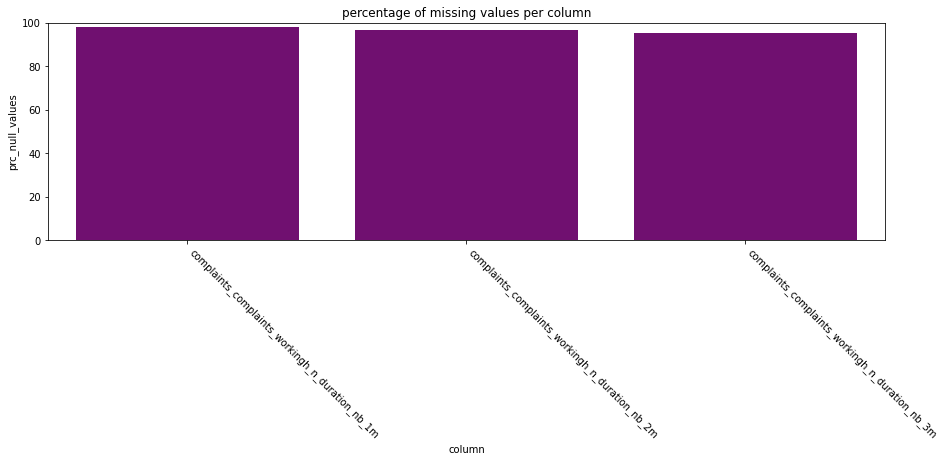

Column family complaints_complaints_workingh_n_total>


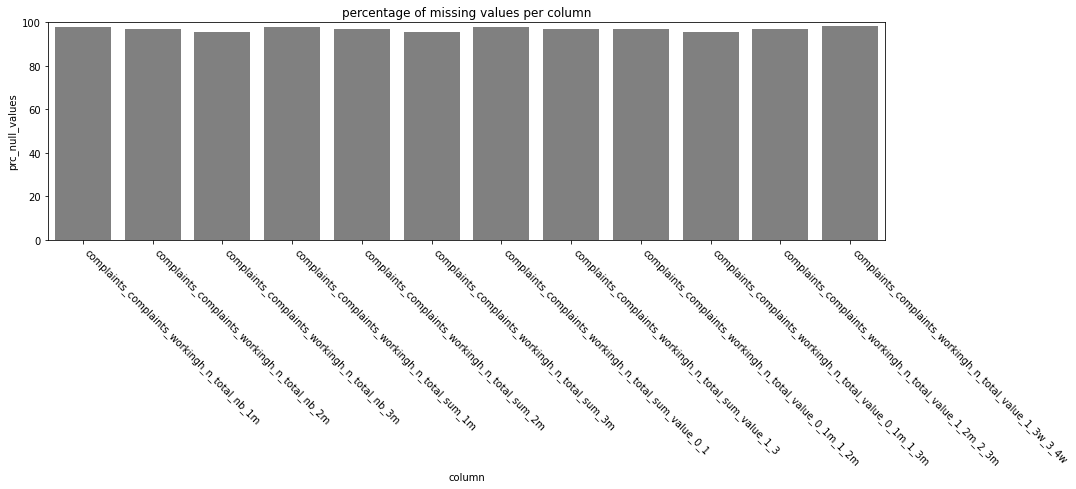

Column family complaints_complaints_workingh_y_duration>


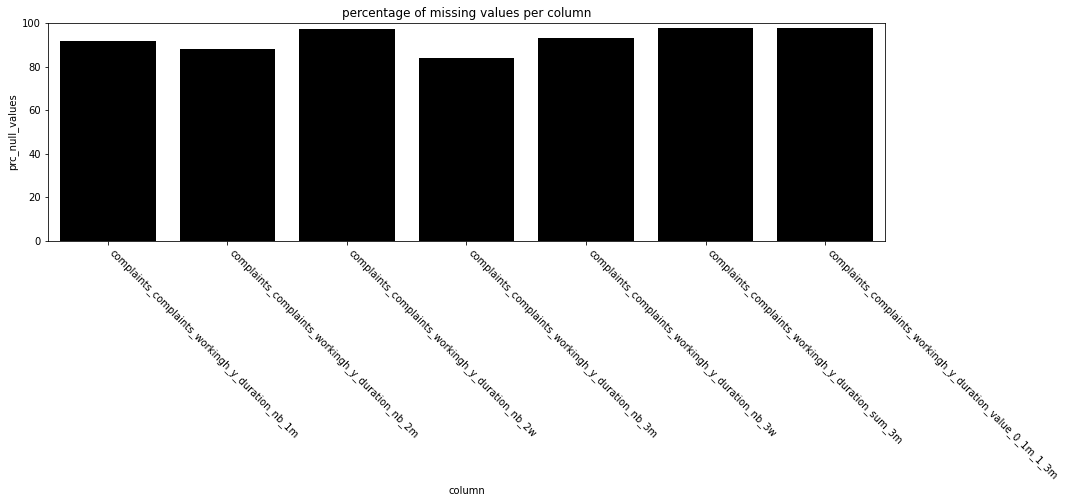

Column family complaints_complaints_workingh_y_total>


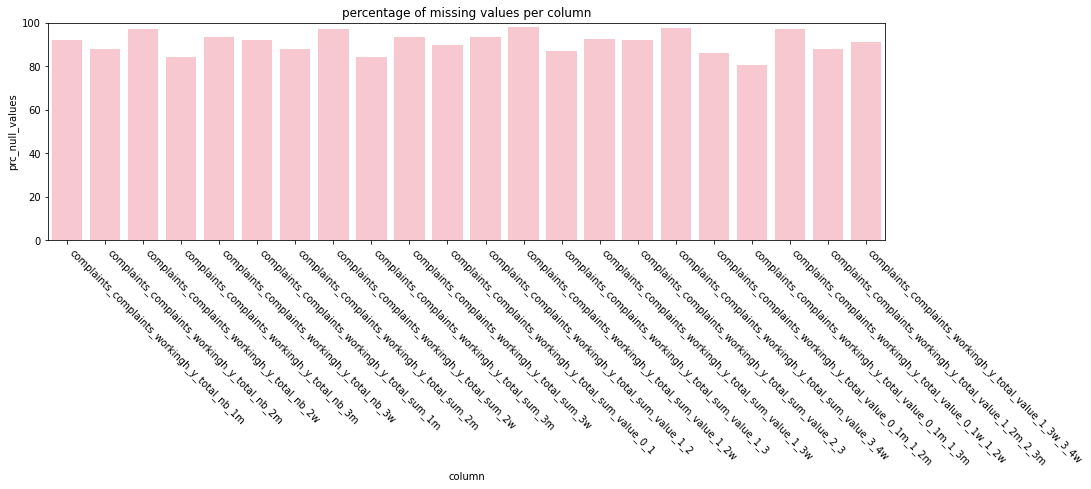

Column family data_roamstate_nonroaming_duration>


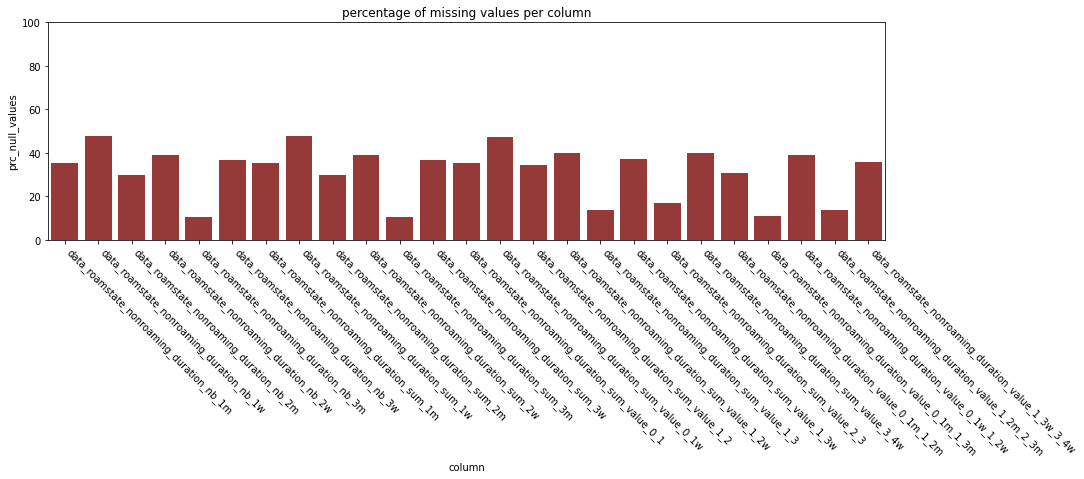

Column family data_roamstate_nonroaming_volume>


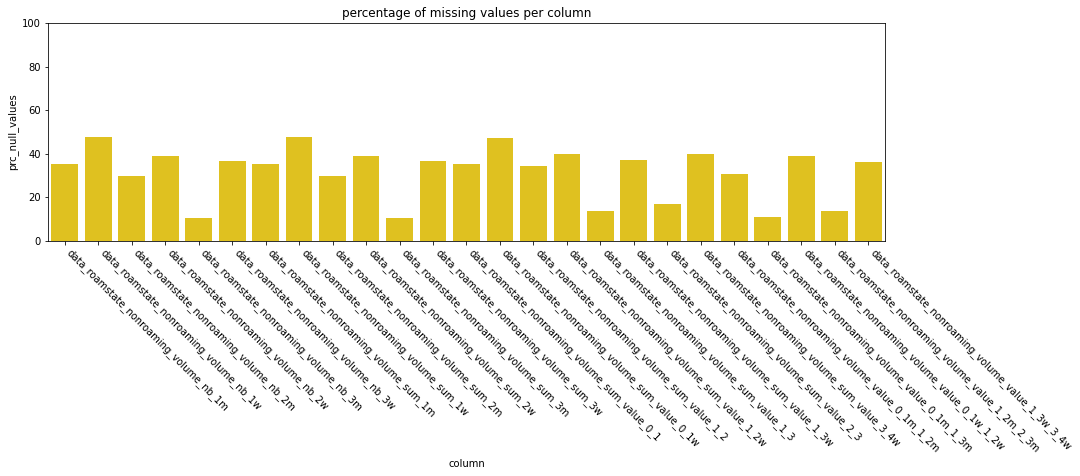

Column family data_usagespecification_localdataservice_duration>


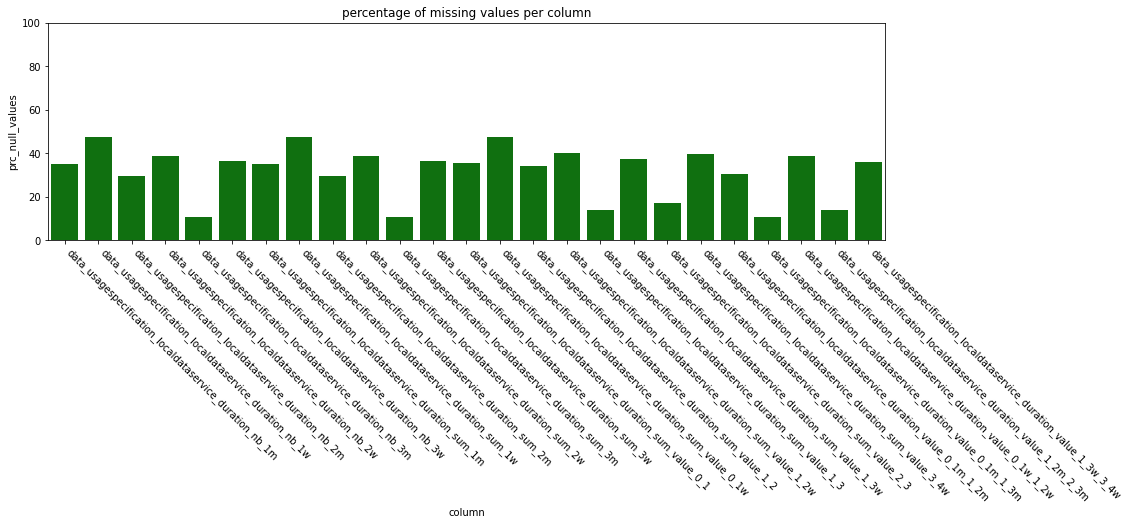

Column family data_usagespecification_localdataservice_volume>


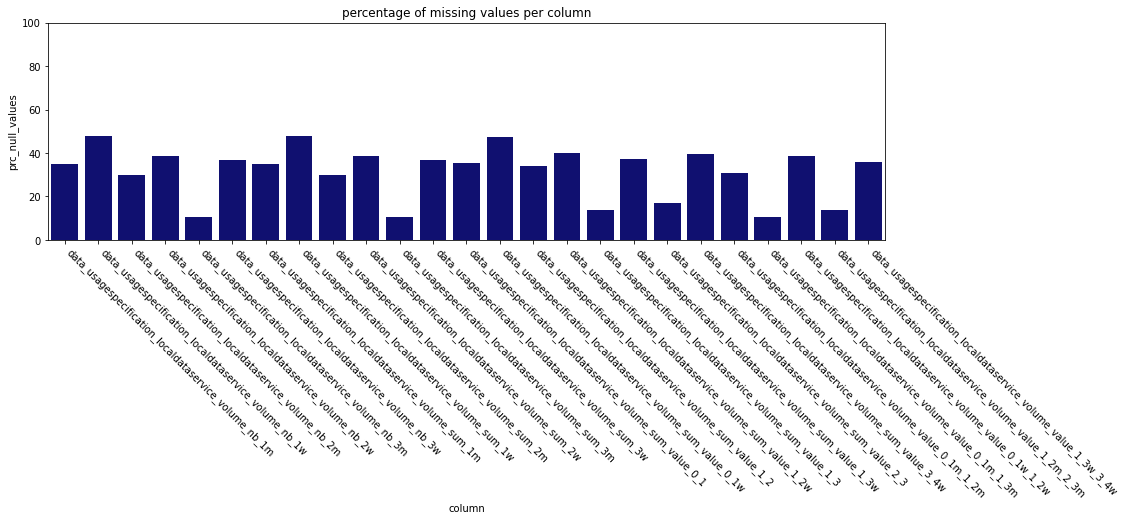

Column family data_weekend_n_duration>


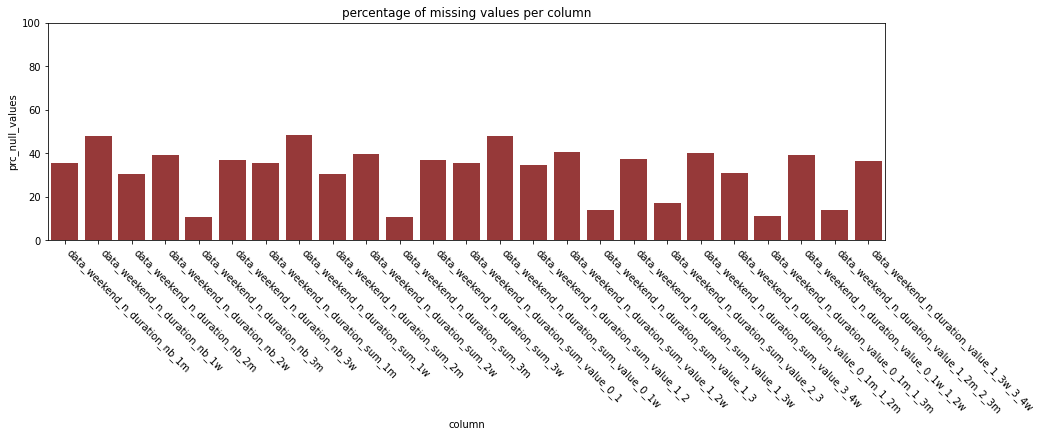

Column family data_weekend_n_volume>


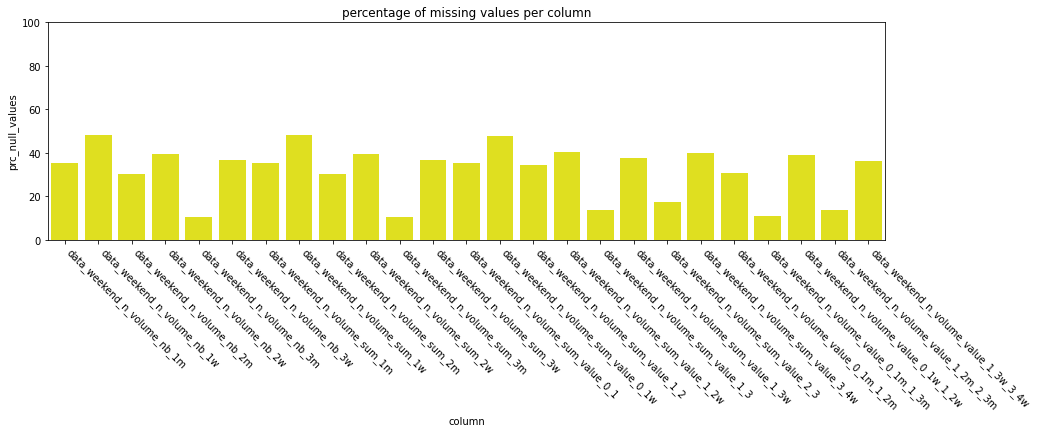

Column family data_weekend_y_duration>


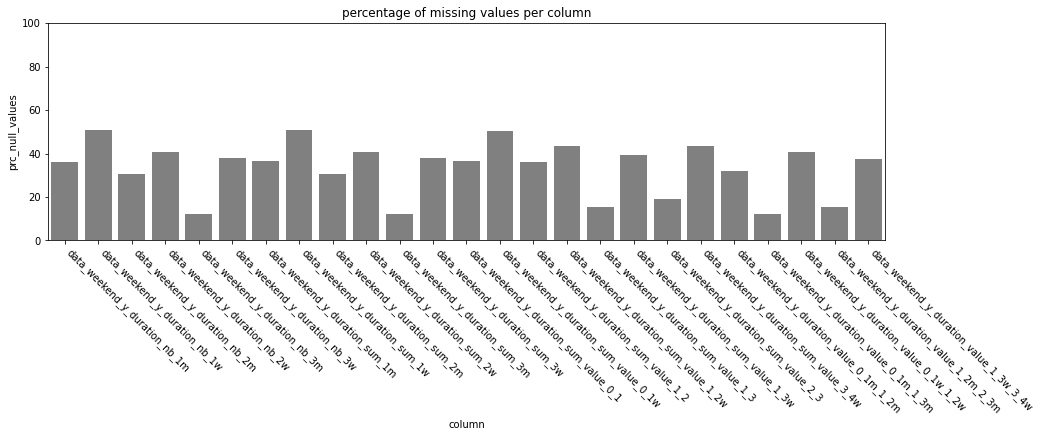

Column family data_weekend_y_volume>


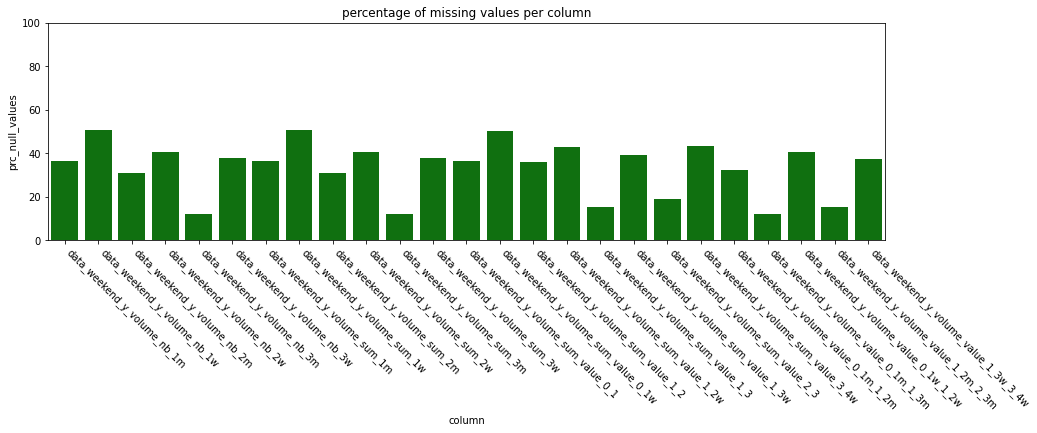

Column family data_workingh_n_duration>


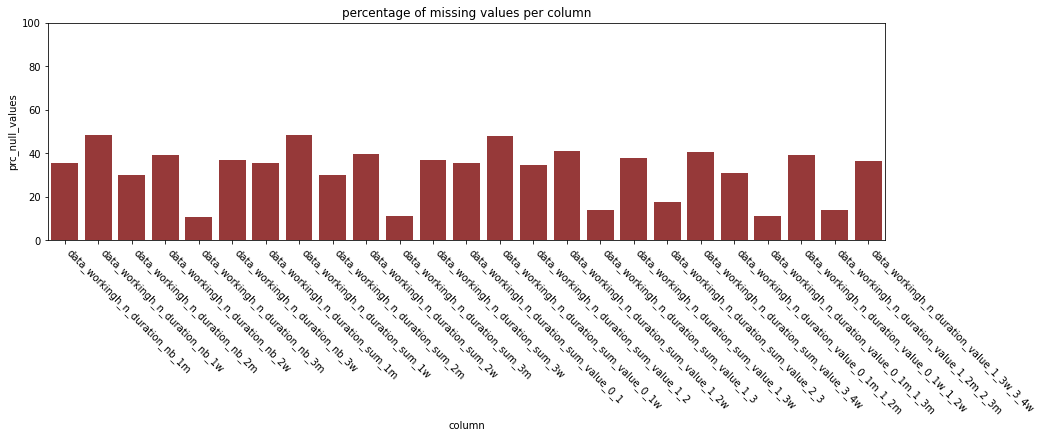

Column family data_workingh_n_volume>


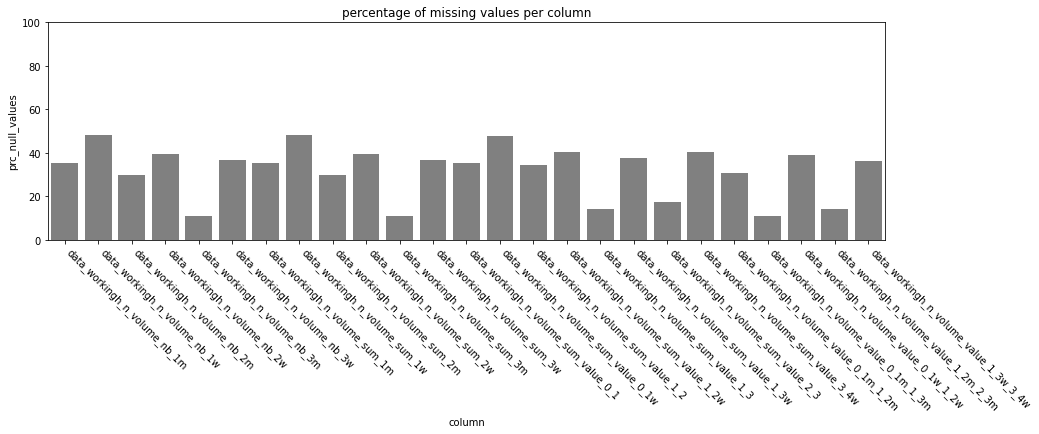

Column family data_workingh_y_duration>


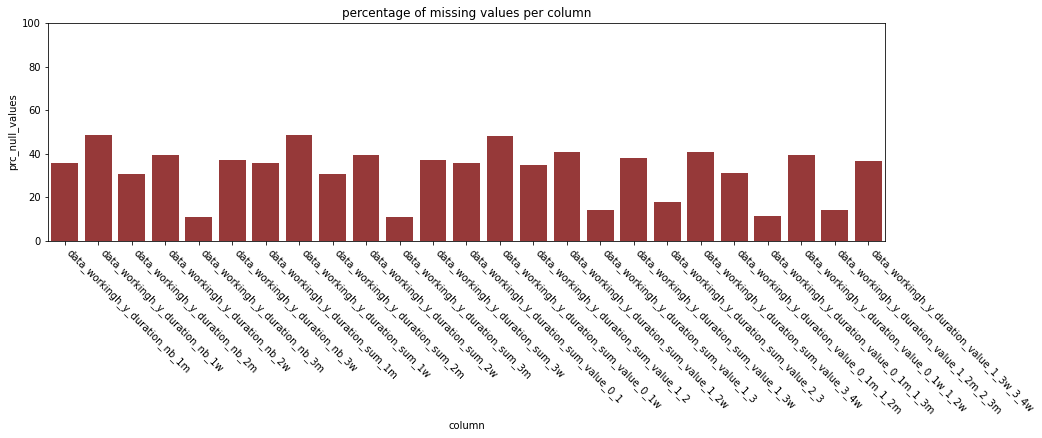

Column family data_workingh_y_volume>


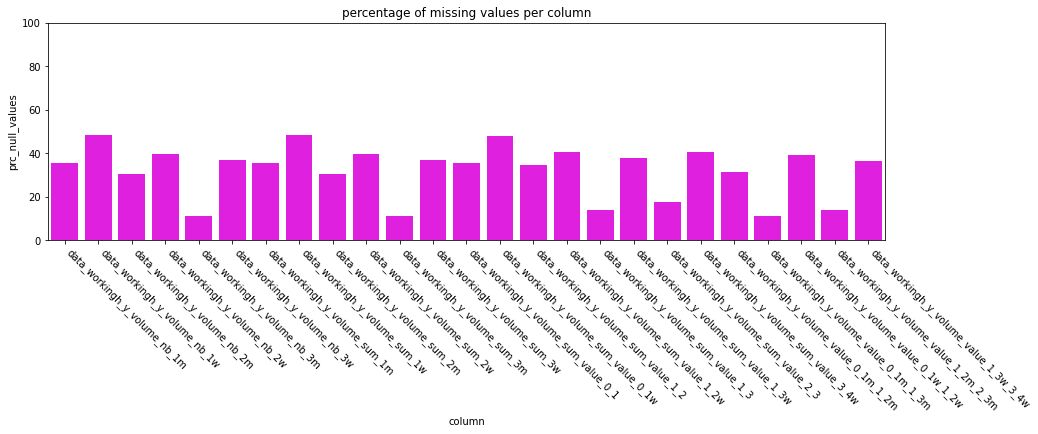

Column family payement_invoice_status_open_open_amount>


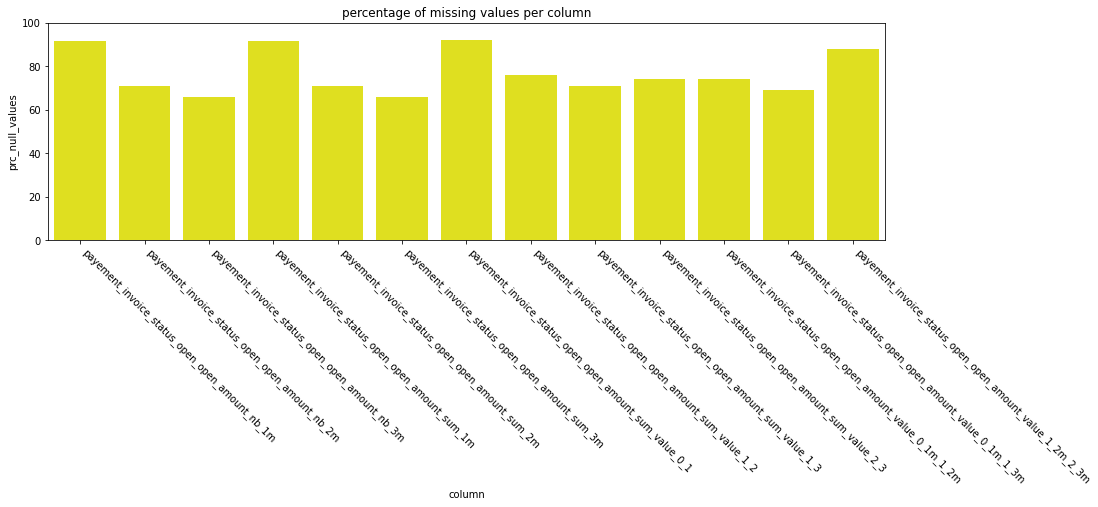

Column family payement_invoice_status_open_pay_delay_could>


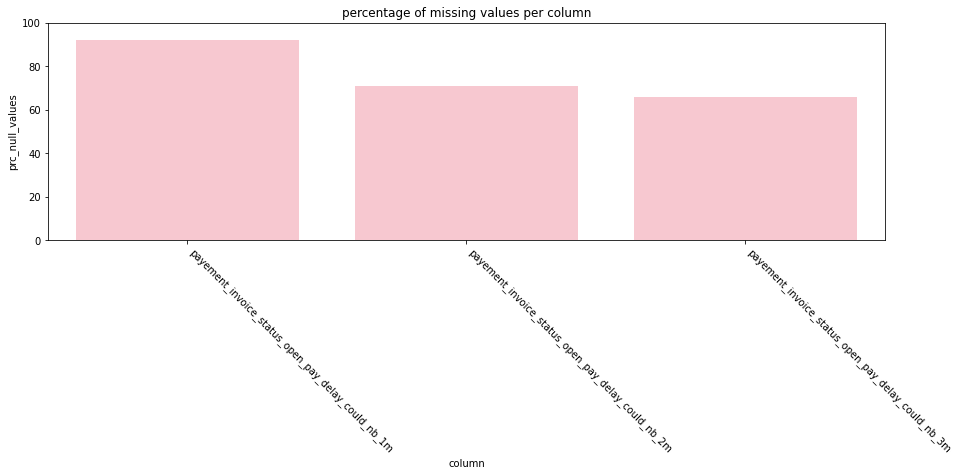

Column family payement_invoice_status_open_pay_delay_should>


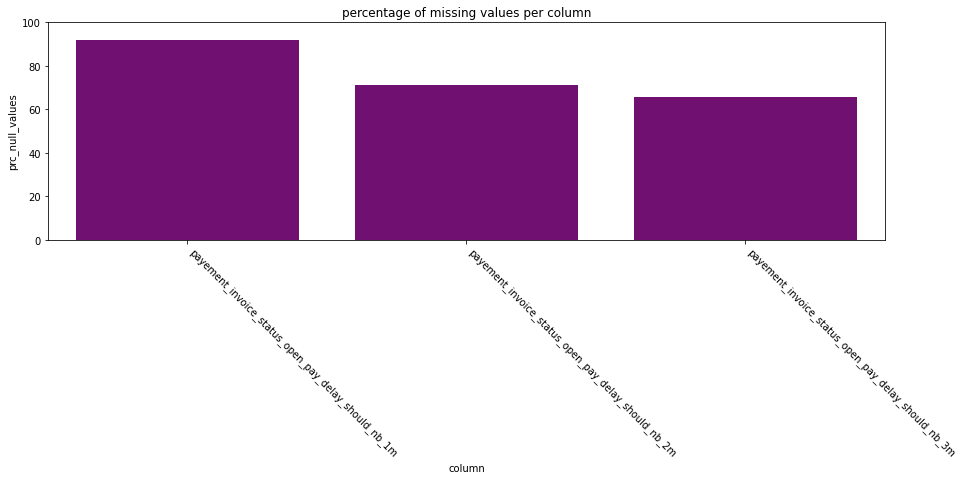

Column family payement_invoice_status_open_pay_total_delay>


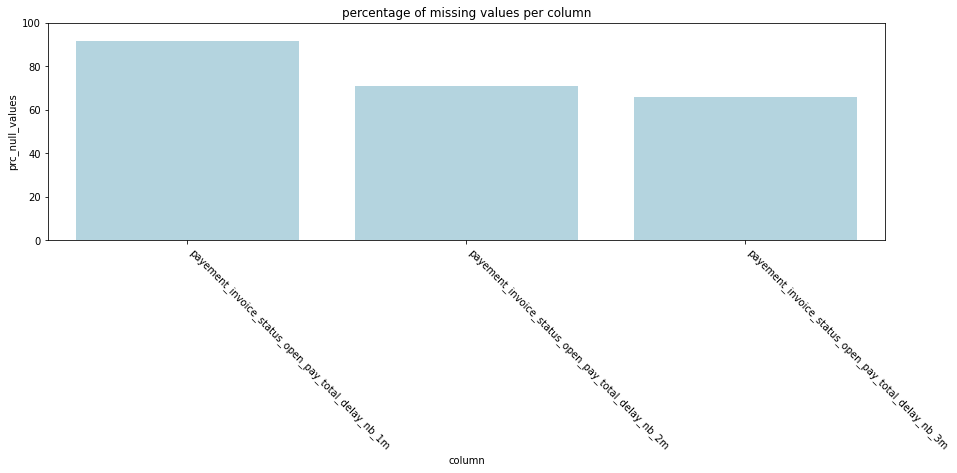

Column family payement_invoice_status_open_perc_paid>


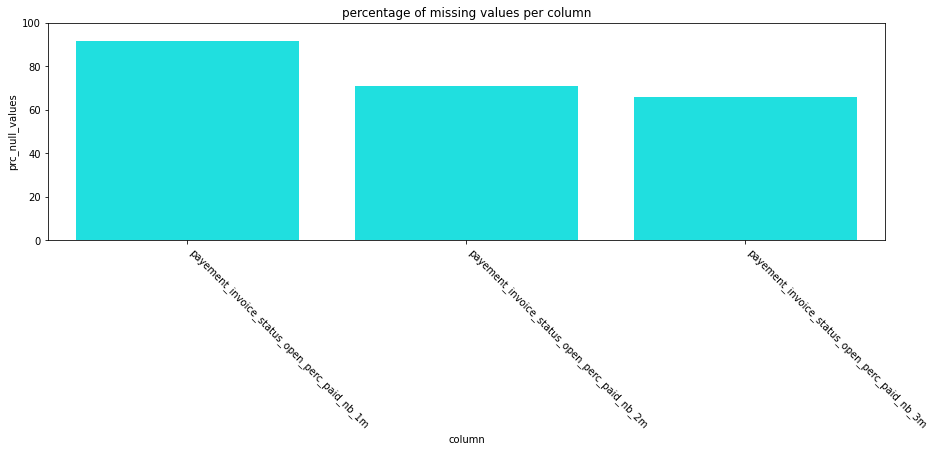

Column family payement_invoice_status_paid_open_amount>


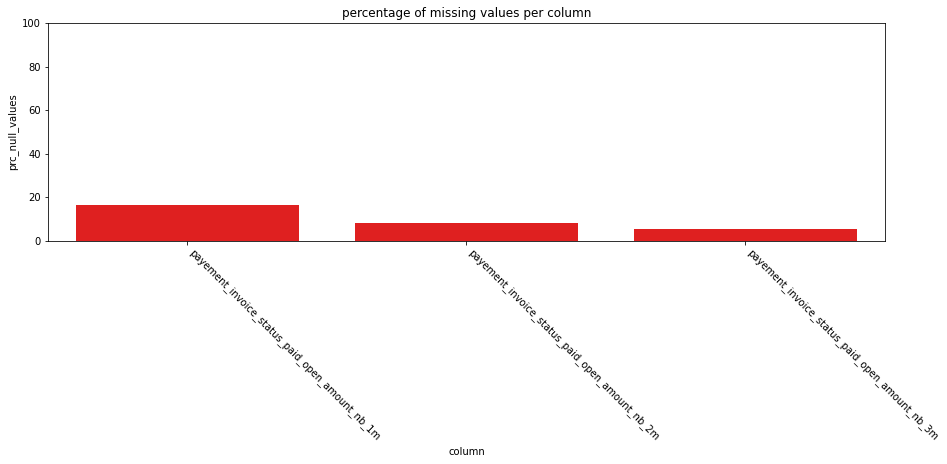

Column family payement_invoice_status_paid_pay_delay_could>


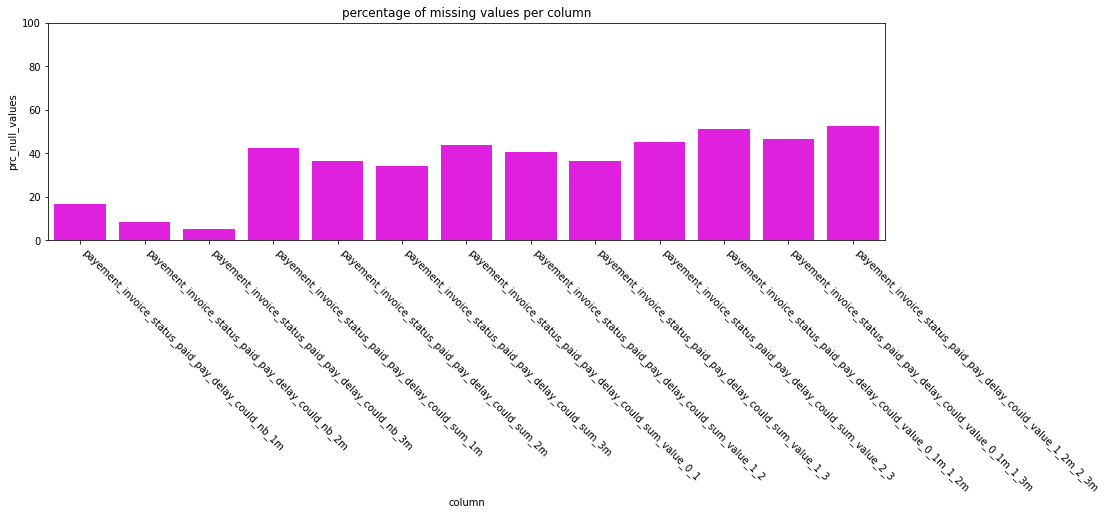

Column family payement_invoice_status_paid_pay_delay_should>


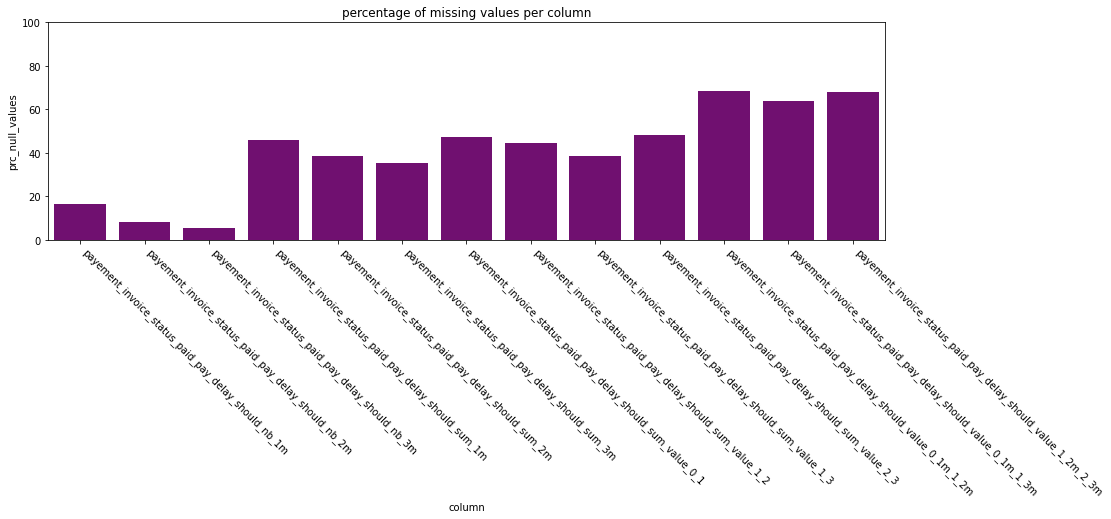

Column family payement_invoice_status_paid_pay_total_delay>


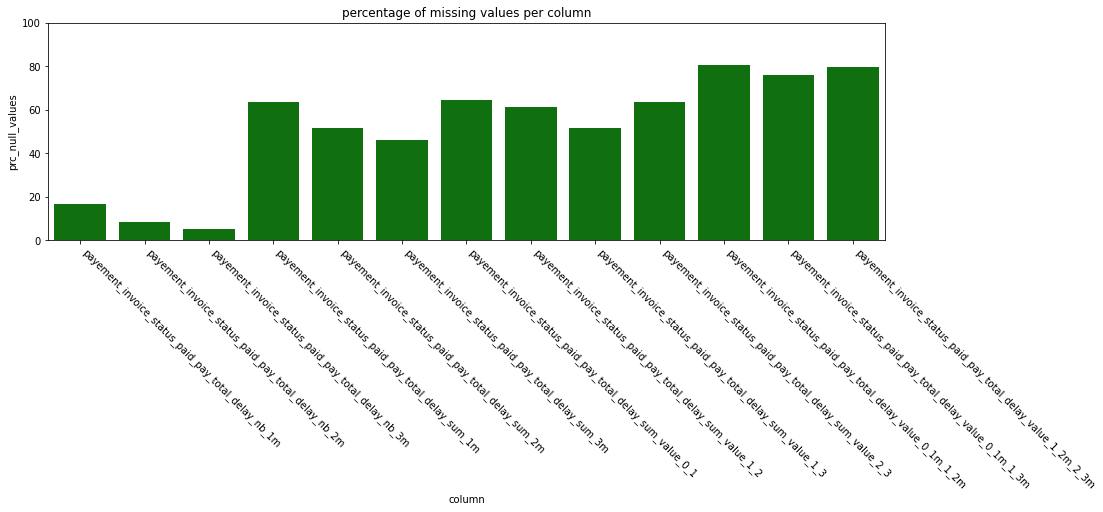

Column family payement_invoice_status_paid_perc_paid>


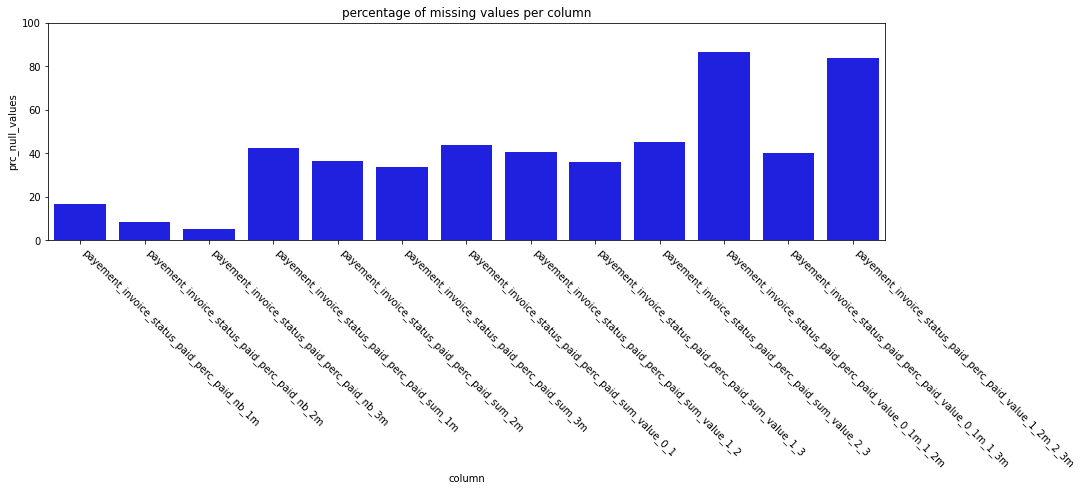

Column family payement_payment_mode_cb_open_amount>


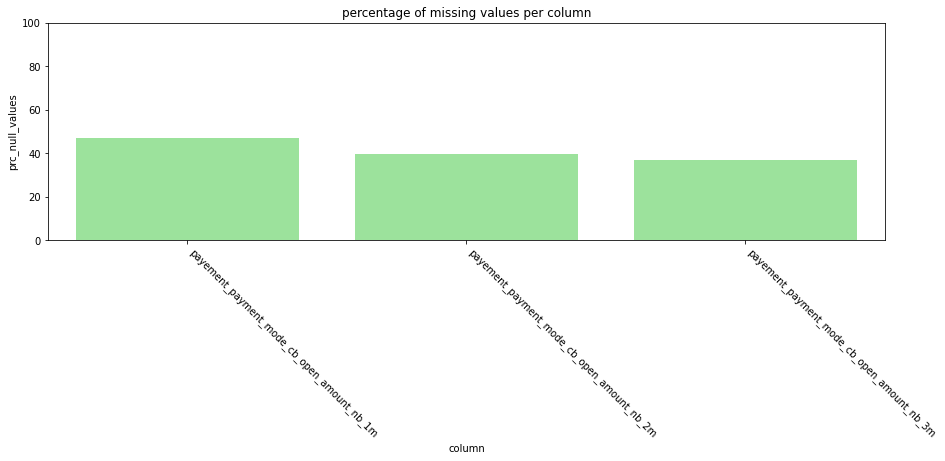

Column family payement_payment_mode_cb_pay_delay_could>


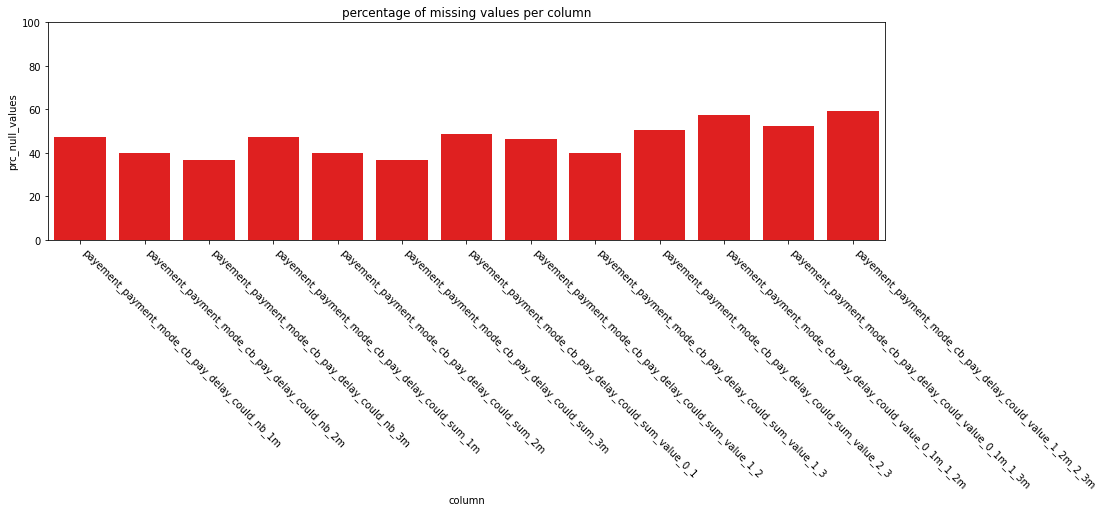

Column family payement_payment_mode_cb_pay_delay_should>


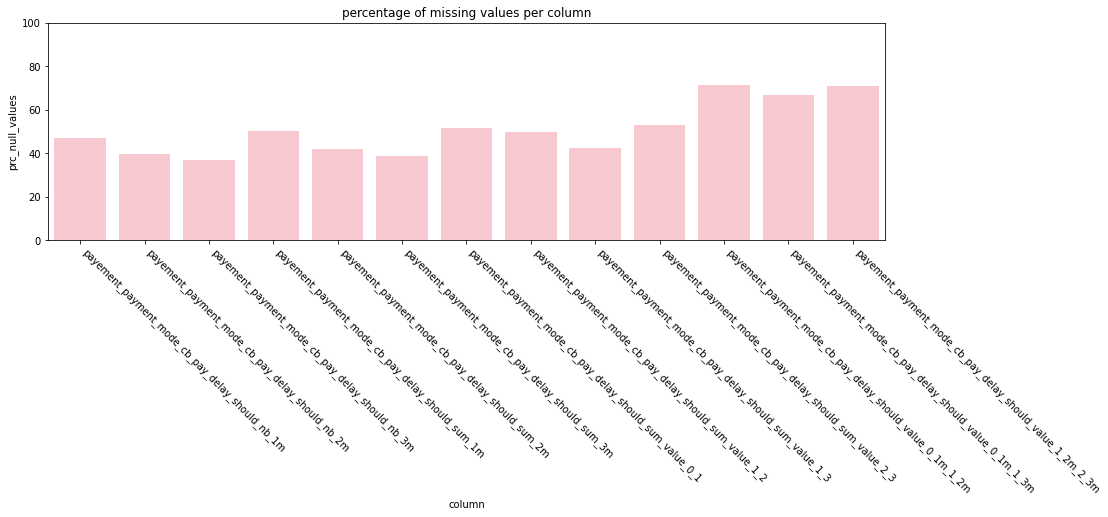

Column family payement_payment_mode_cb_pay_total_delay>


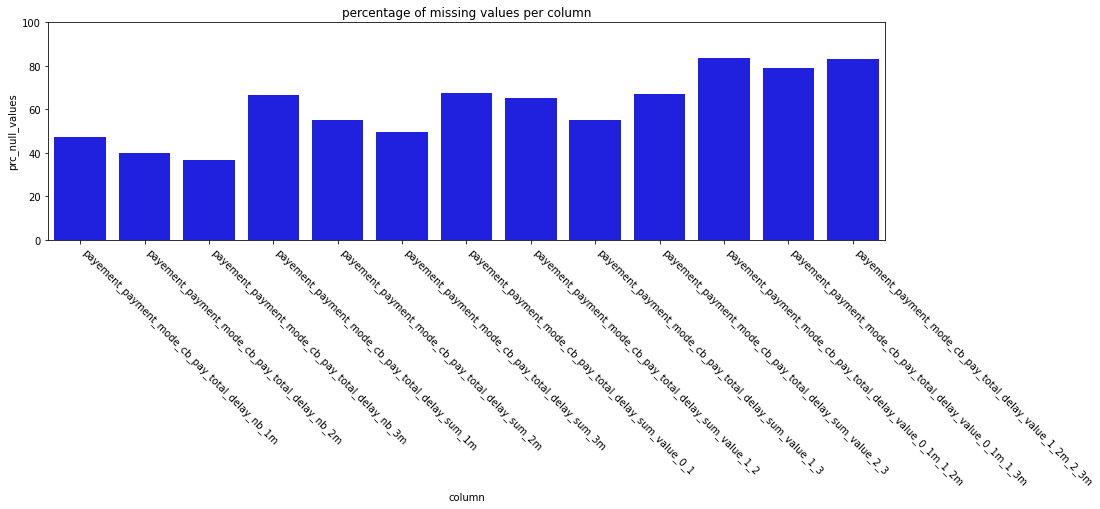

Column family payement_payment_mode_cb_perc_paid>


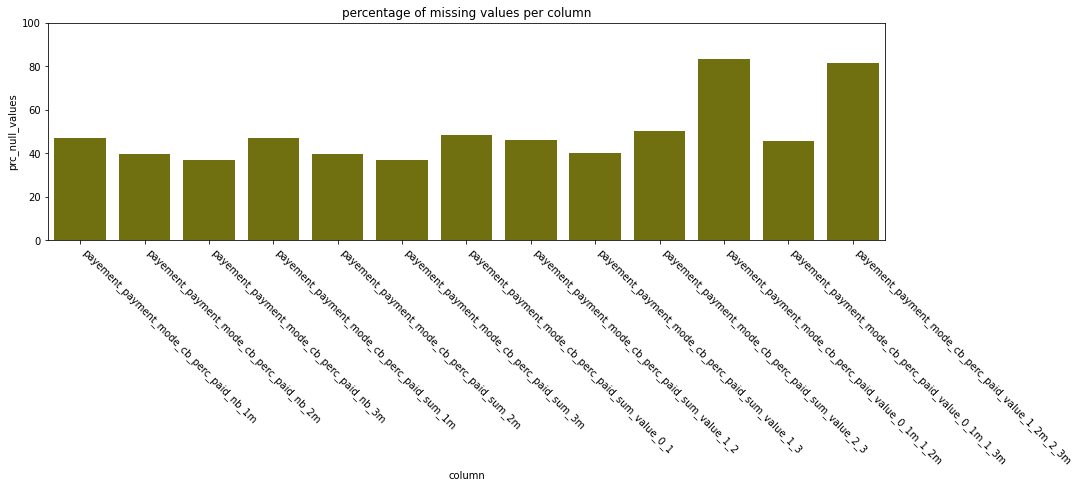

Column family payement_payment_mode_especes_open_amount>


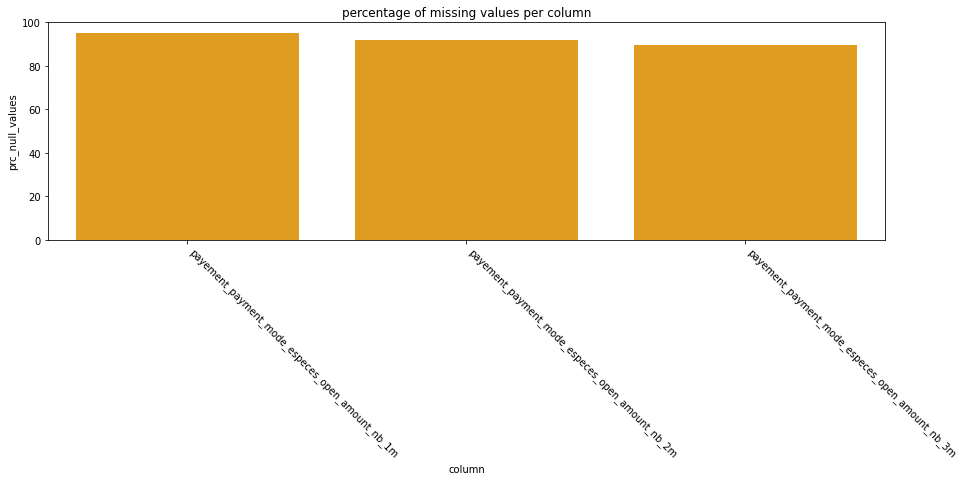

Column family payement_payment_mode_especes_pay_delay_could>


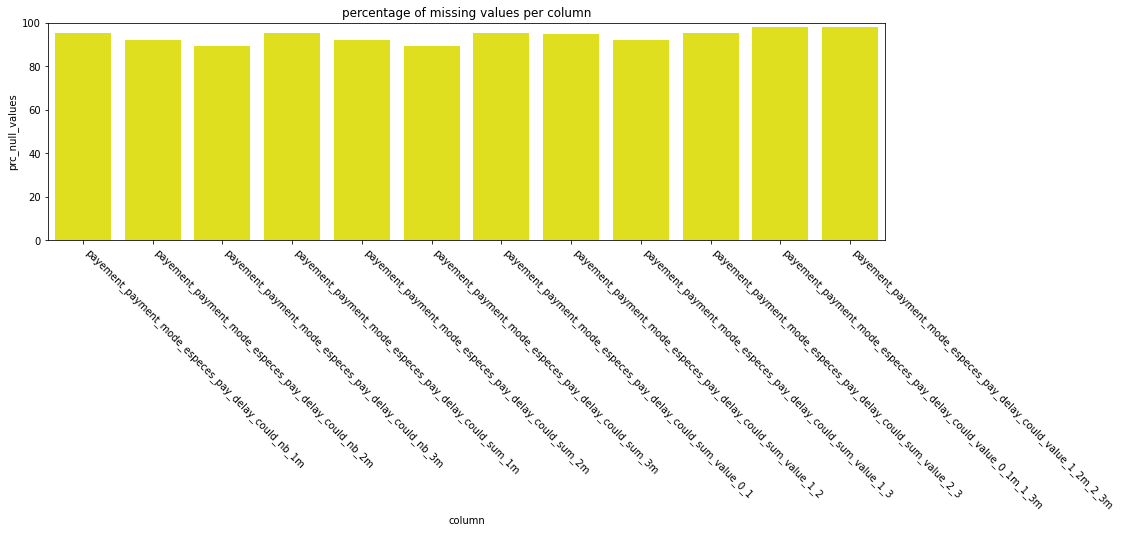

Column family payement_payment_mode_especes_pay_delay_should>


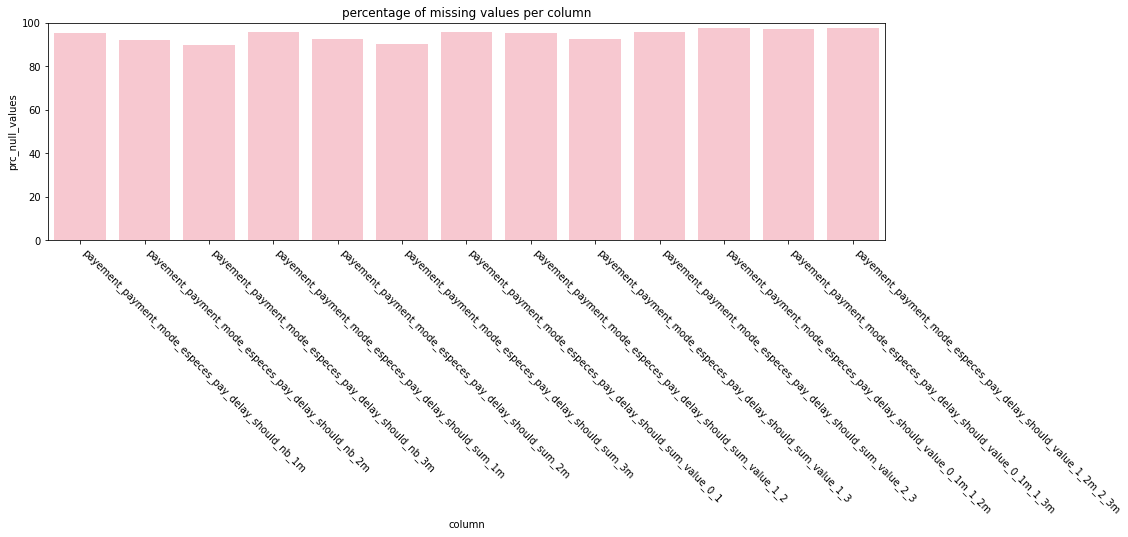

Column family payement_payment_mode_especes_pay_total_delay>


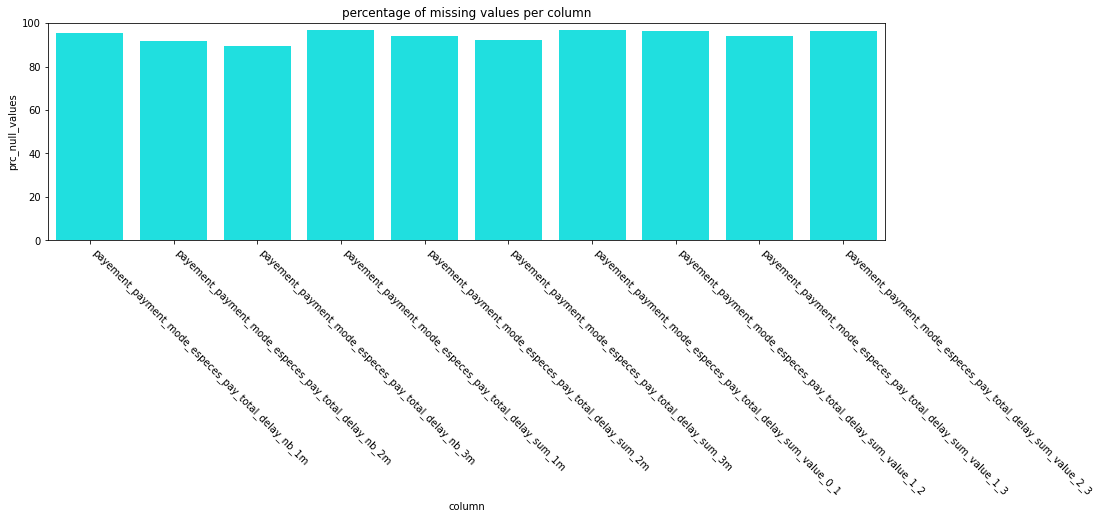

Column family payement_payment_mode_especes_perc_paid>


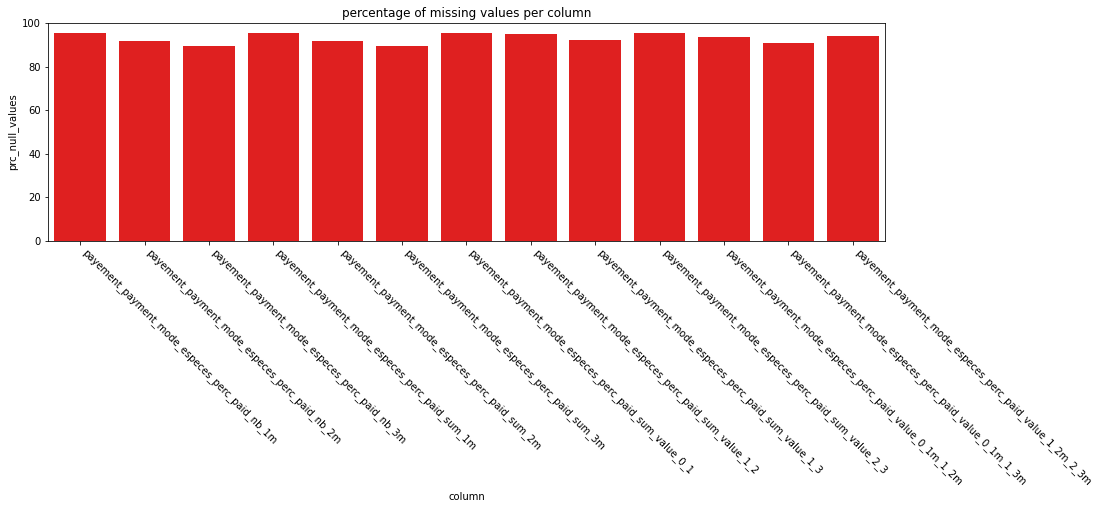

Column family payement_payment_mode_na_open_amount>


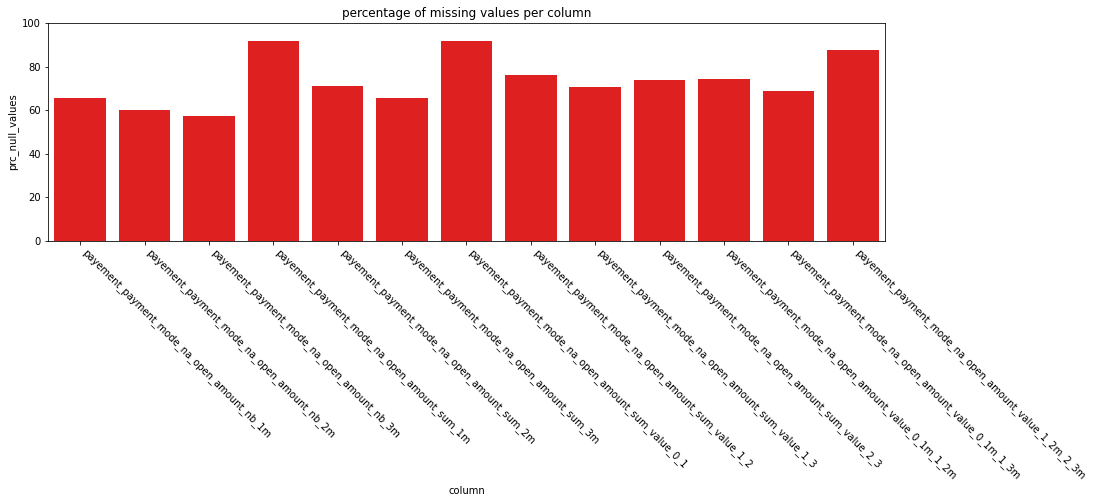

Column family payement_payment_mode_na_pay_delay_could>


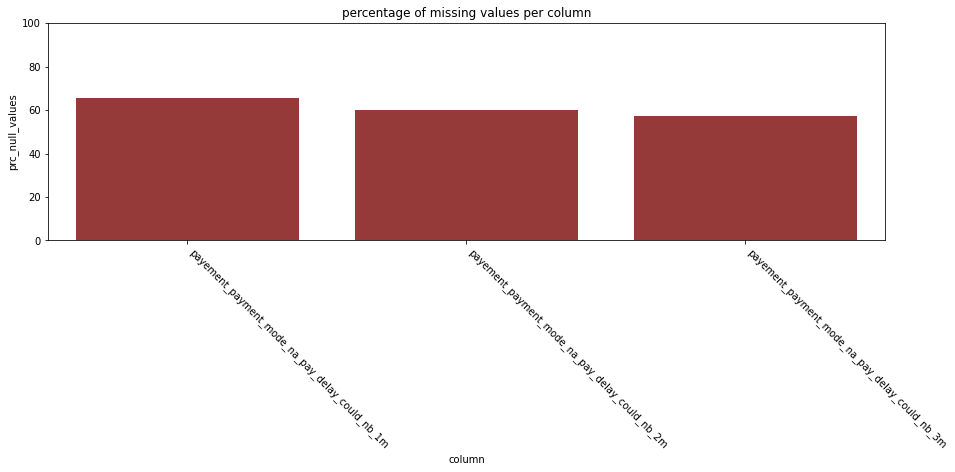

Column family payement_payment_mode_na_pay_delay_should>


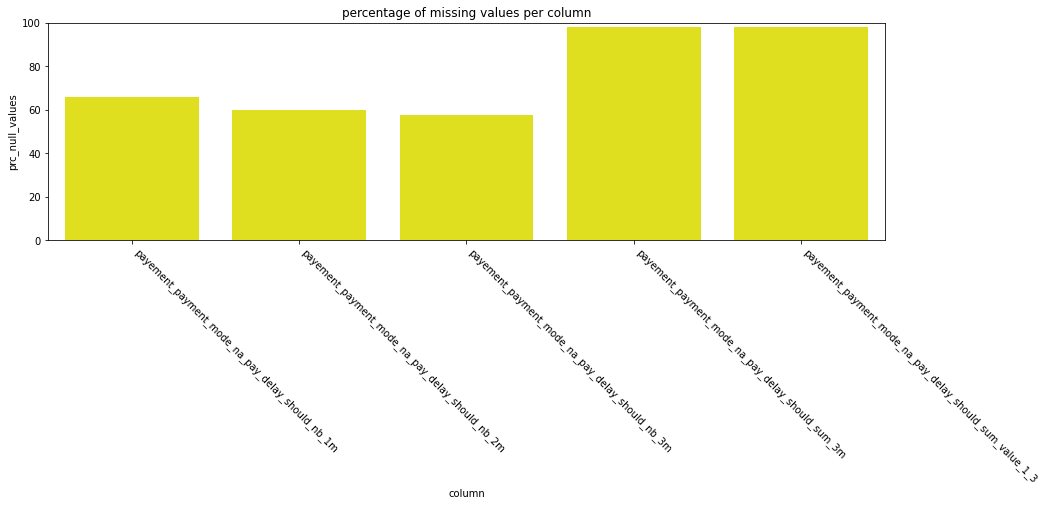

Column family payement_payment_mode_na_pay_total_delay>


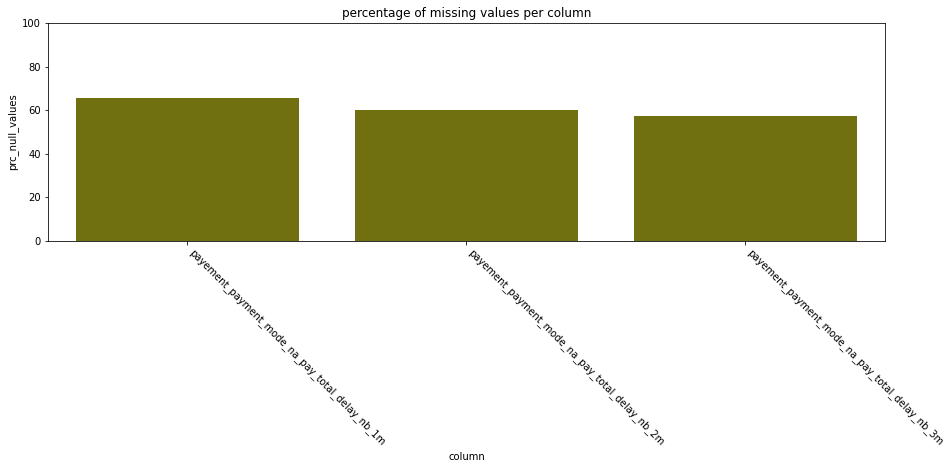

Column family payement_payment_mode_na_perc_paid>


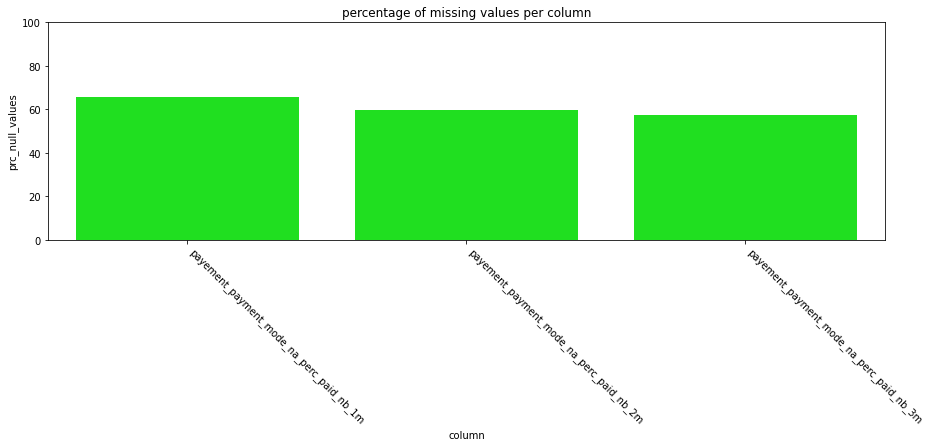

Column family payement_payment_way_internet_open_amount>


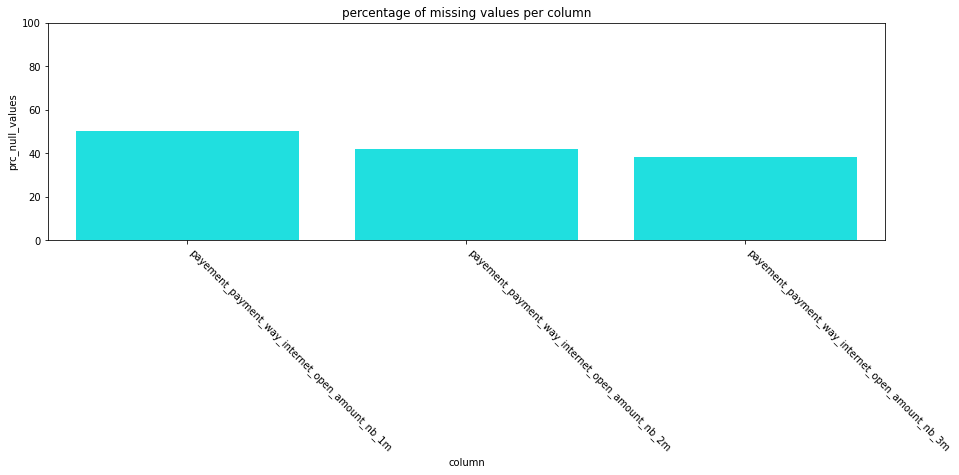

Column family payement_payment_way_internet_pay_delay_could>


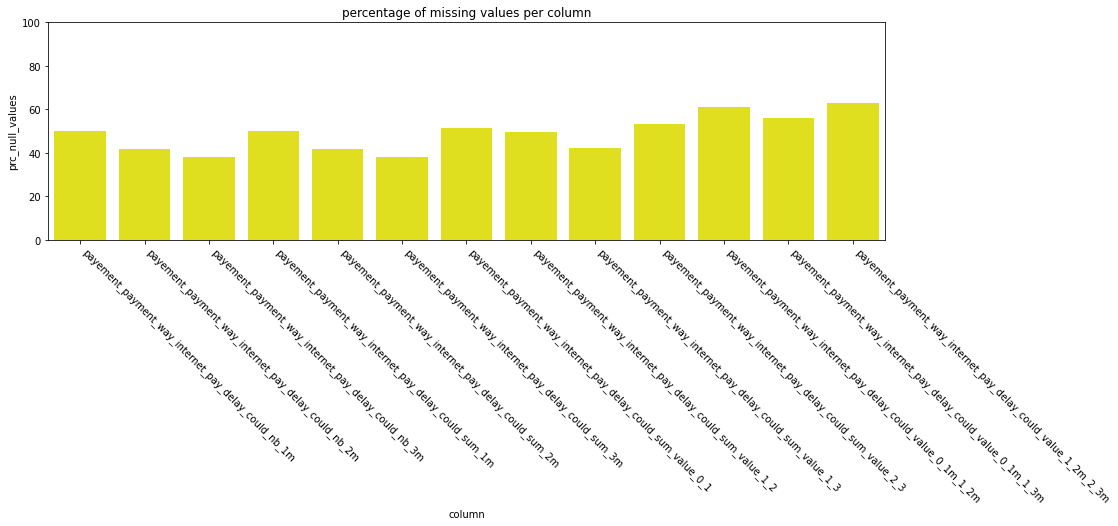

Column family payement_payment_way_internet_pay_delay_should>


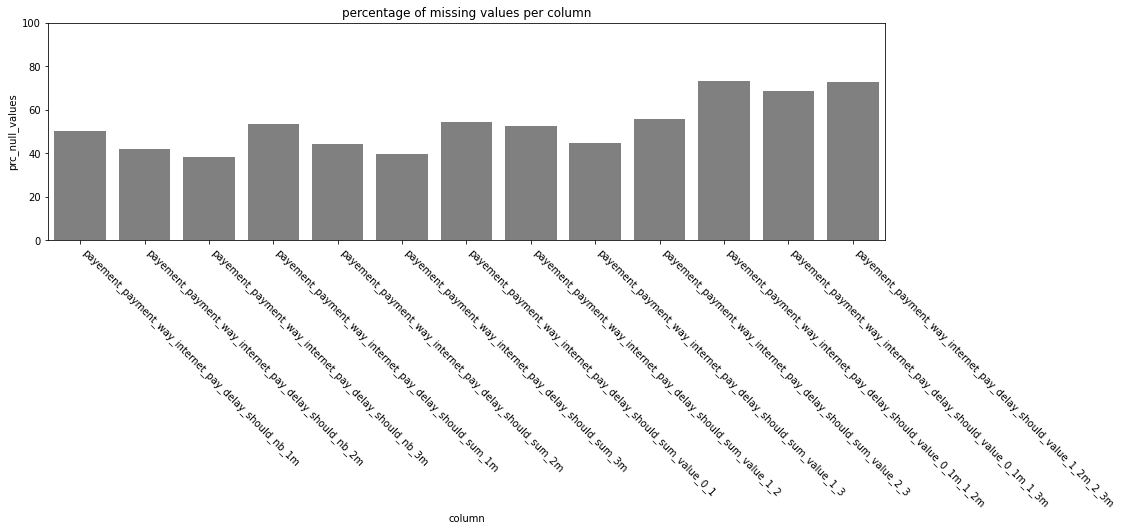

Column family payement_payment_way_internet_pay_total_delay>


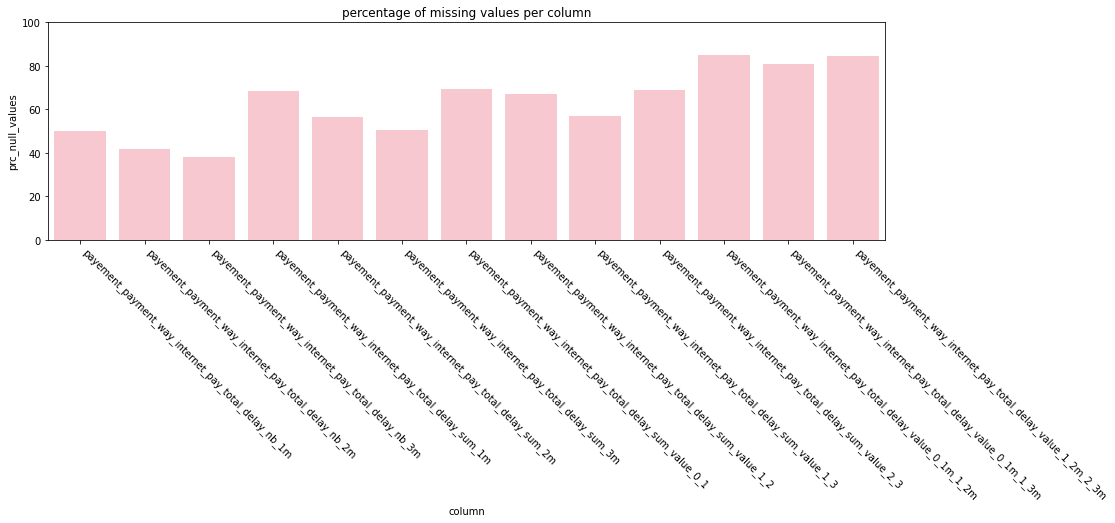

Column family payement_payment_way_internet_perc_paid>


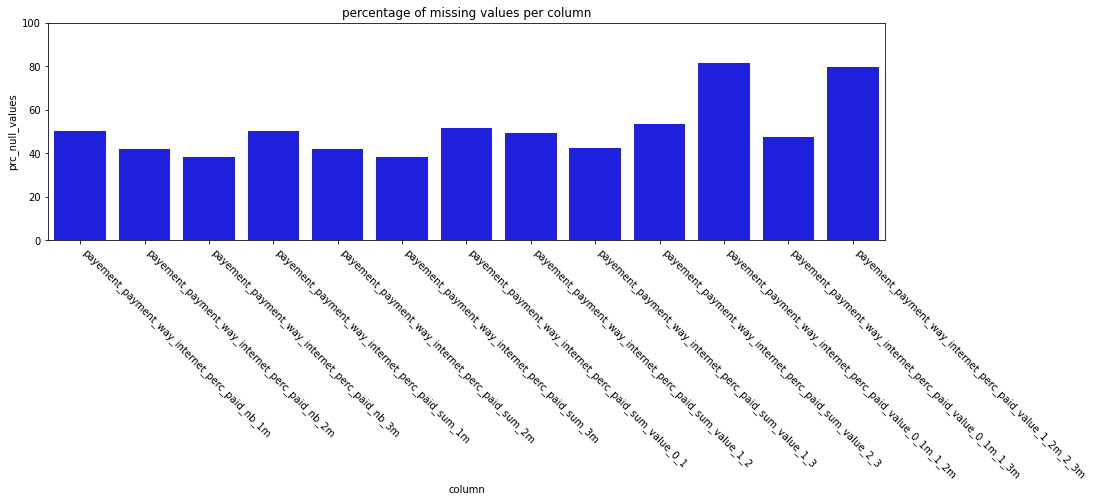

Column family payement_payment_way_na_open_amount>


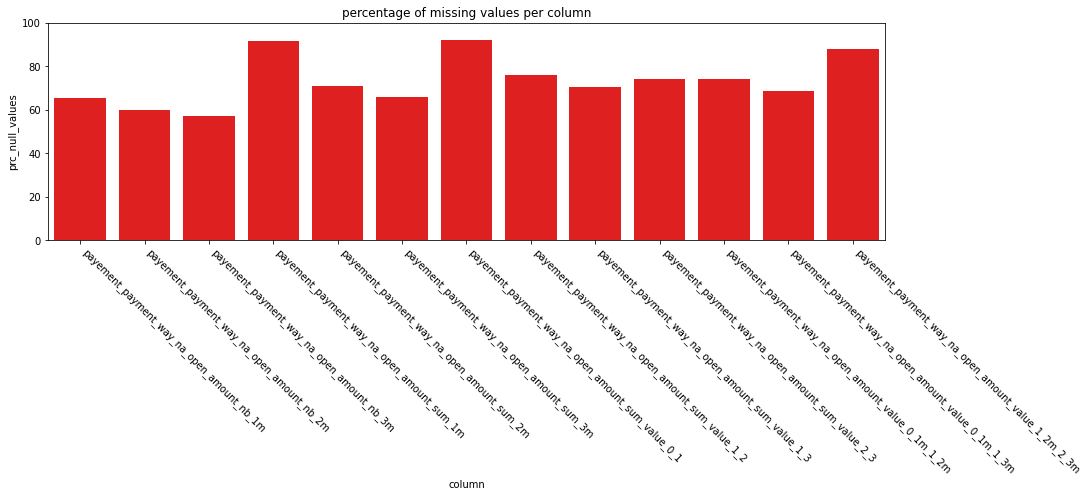

Column family payement_payment_way_na_pay_delay_could>


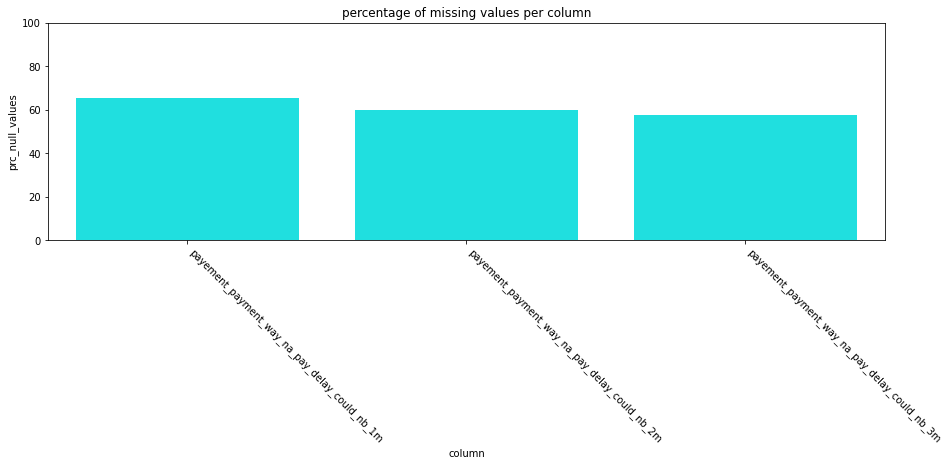

Column family payement_payment_way_na_pay_delay_should>


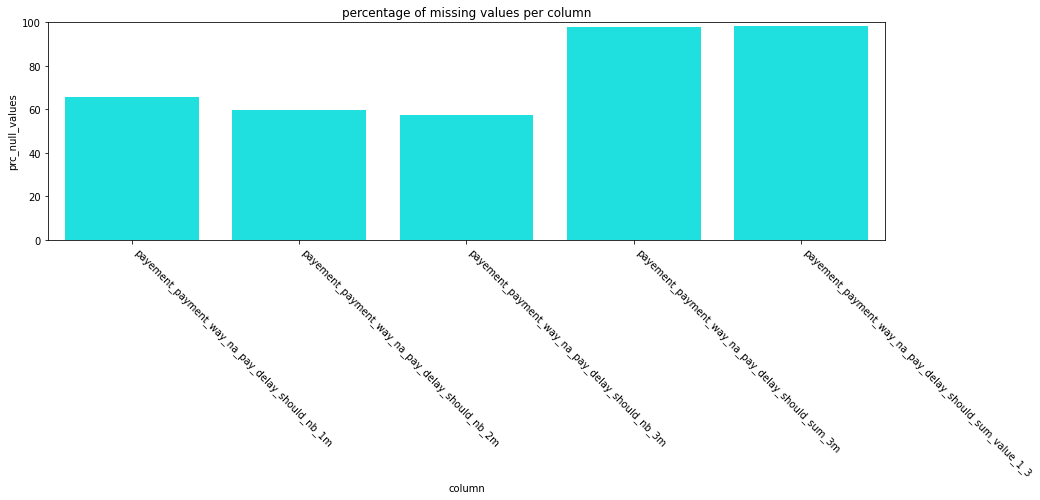

Column family payement_payment_way_na_pay_total_delay>


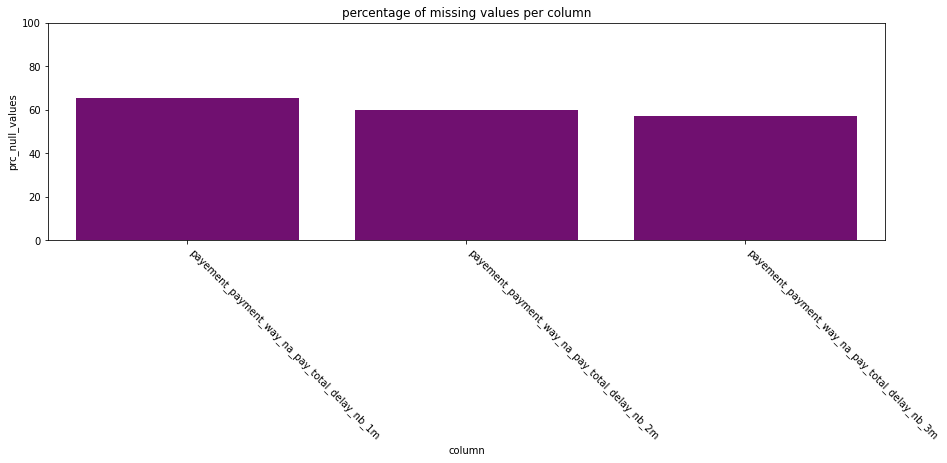

Column family payement_payment_way_na_perc_paid>


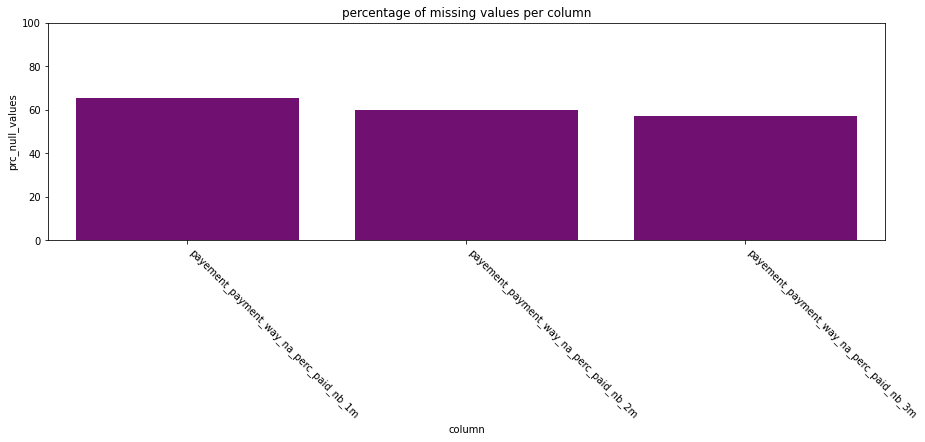

Column family payement_payment_way_ussd_open_amount>


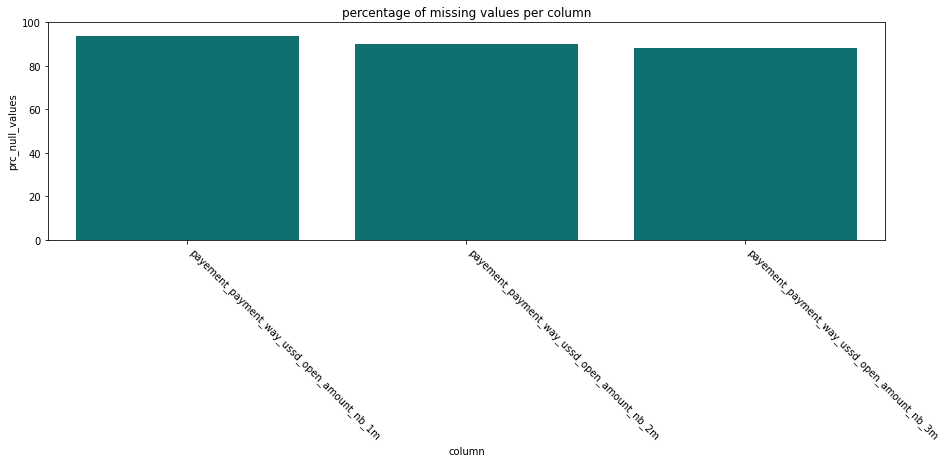

Column family payement_payment_way_ussd_pay_delay_could>


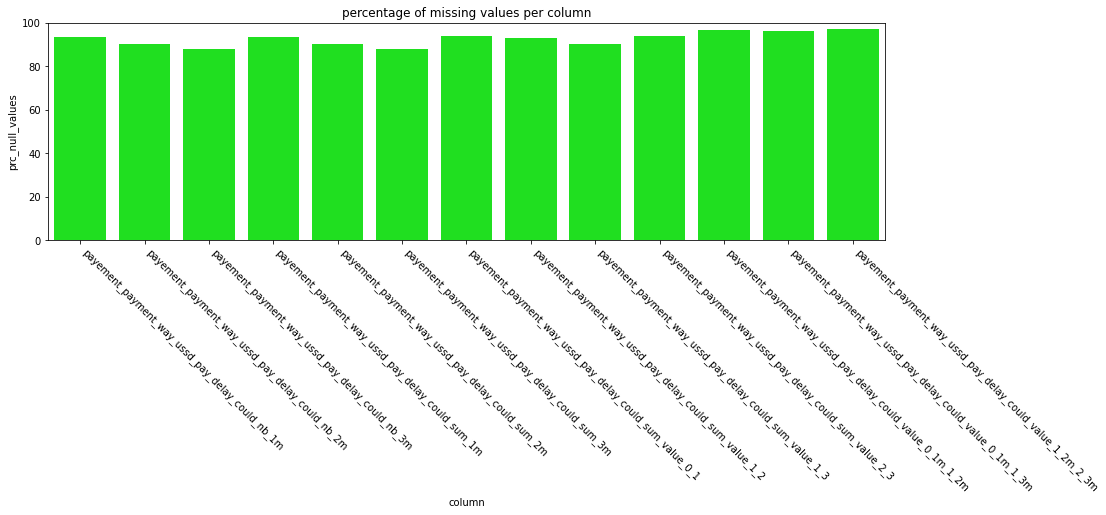

Column family payement_payment_way_ussd_pay_delay_should>


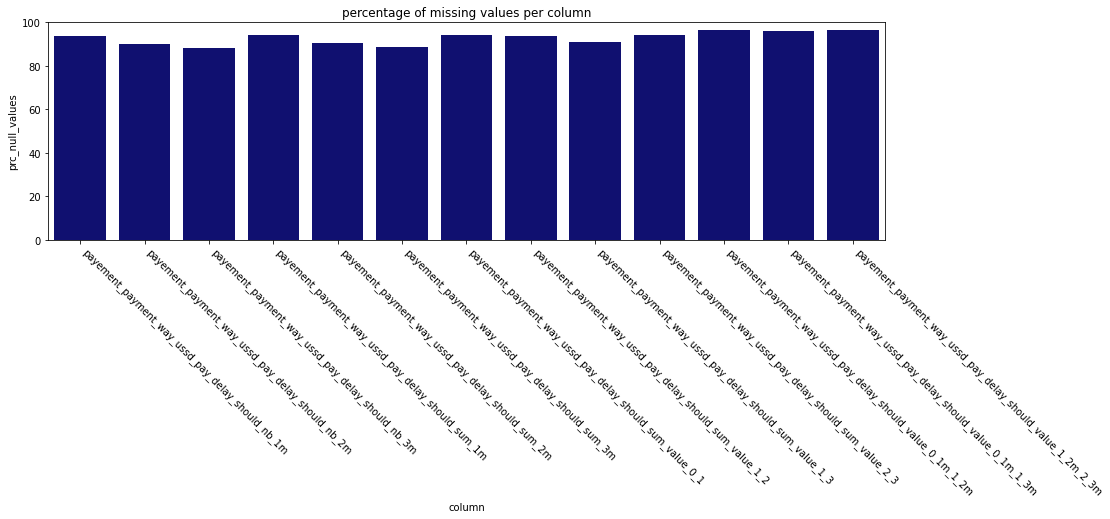

Column family payement_payment_way_ussd_pay_total_delay>


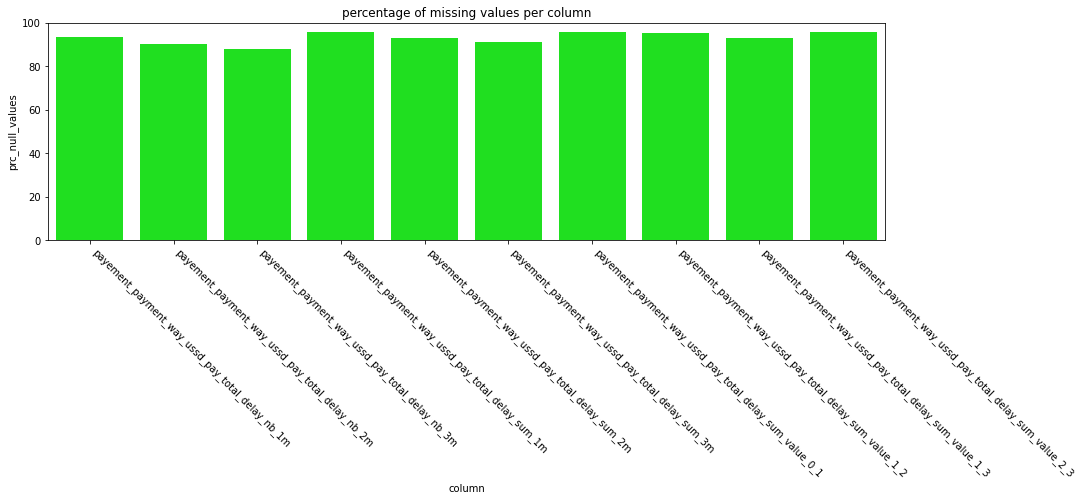

Column family payement_payment_way_ussd_perc_paid>


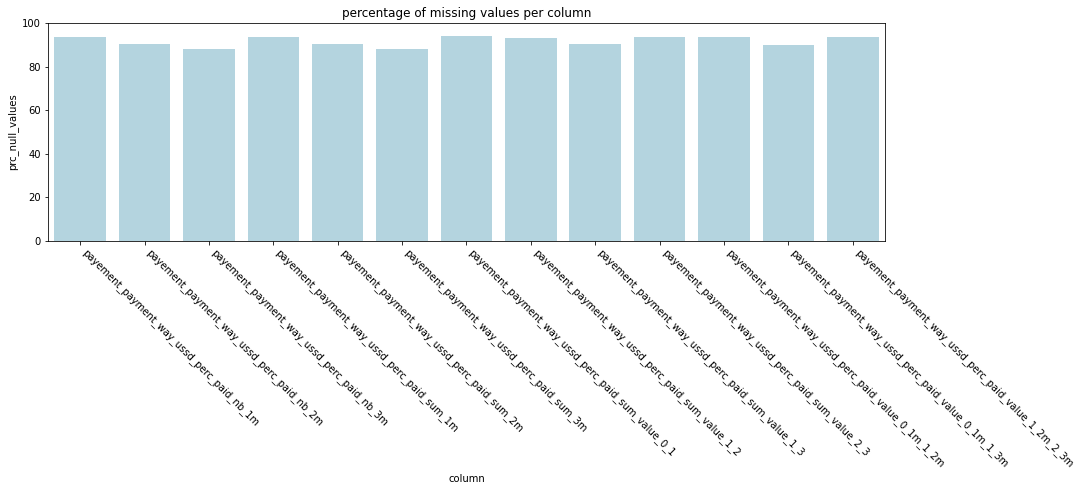

Column family voice_call_direction_oc_duration>


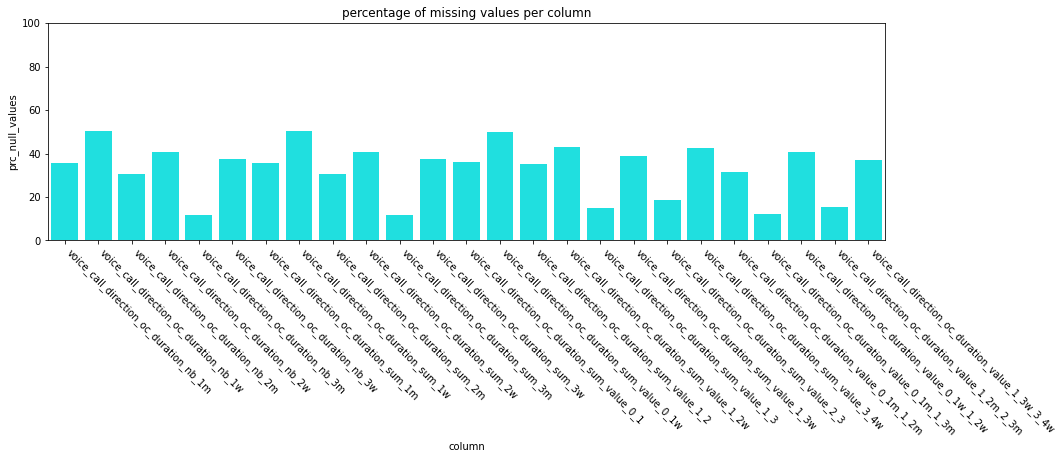

Column family voice_destination_type_international_duration>


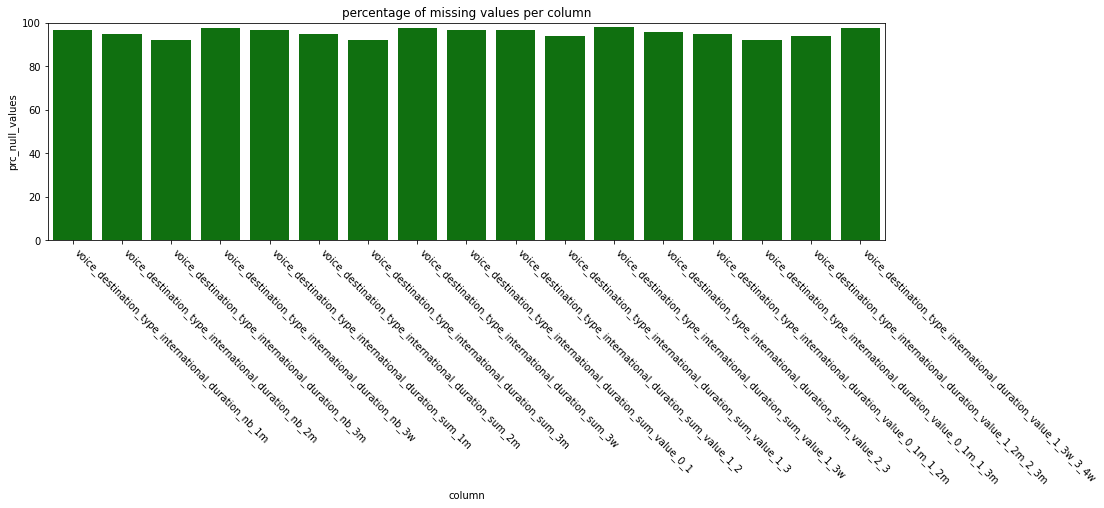

Column family voice_destination_type_national_duration>


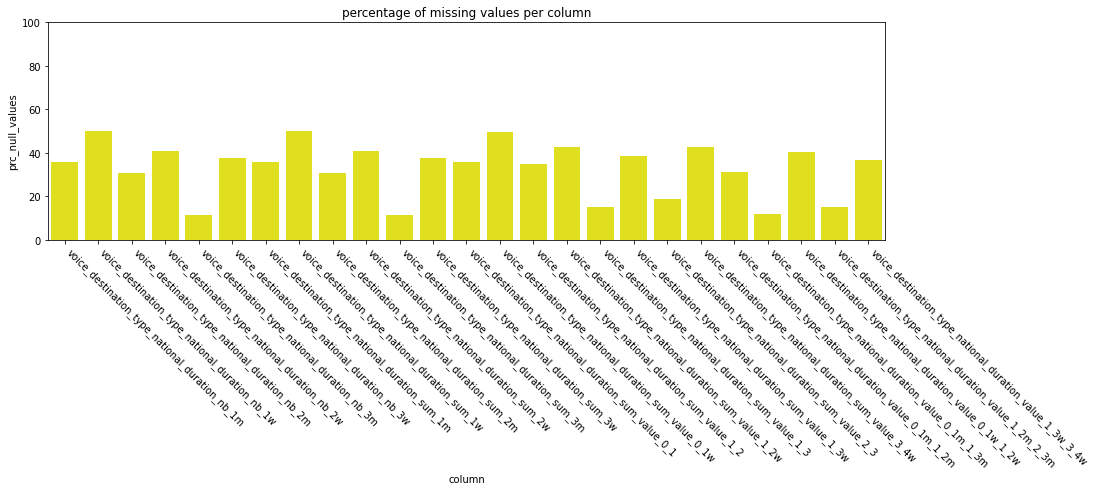

Column family voice_termination_type_offnet_duration>


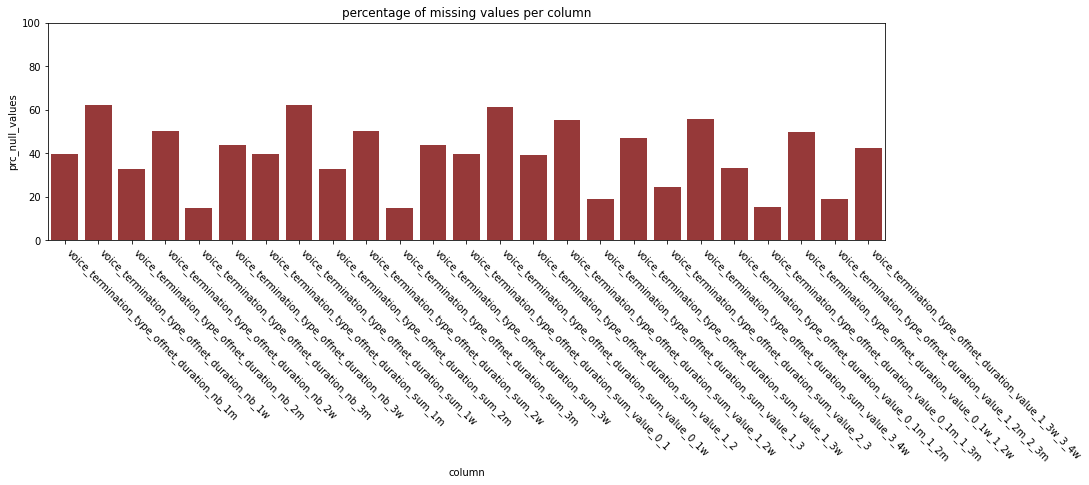

Column family voice_termination_type_onnet_duration>


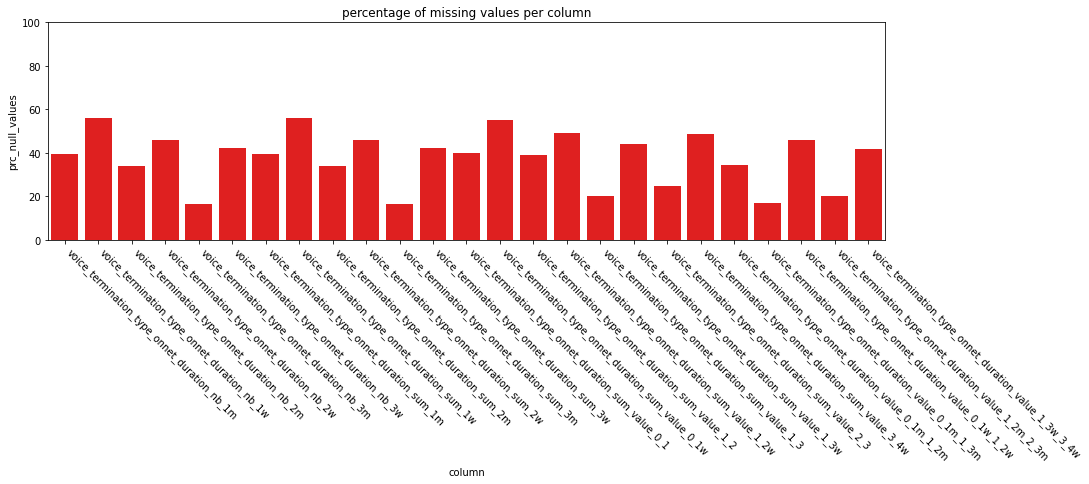

Column family voice_weekend_n_duration>


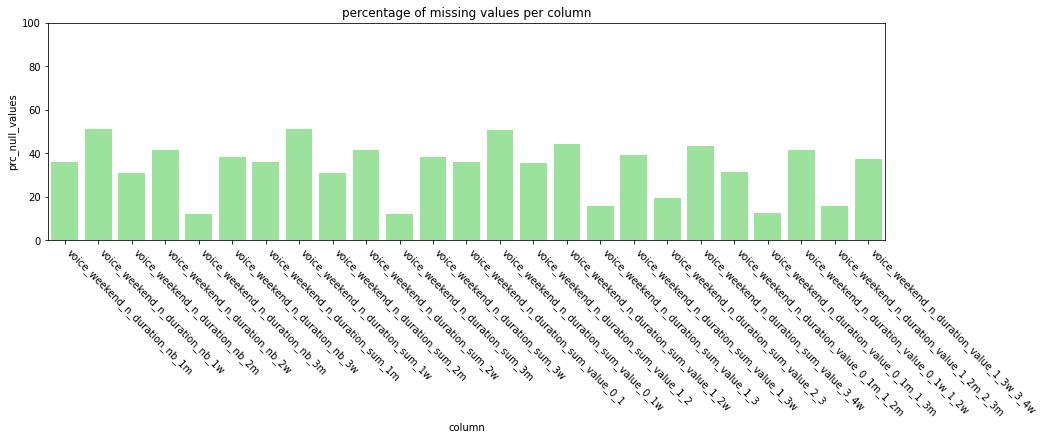

Column family voice_weekend_y_duration>


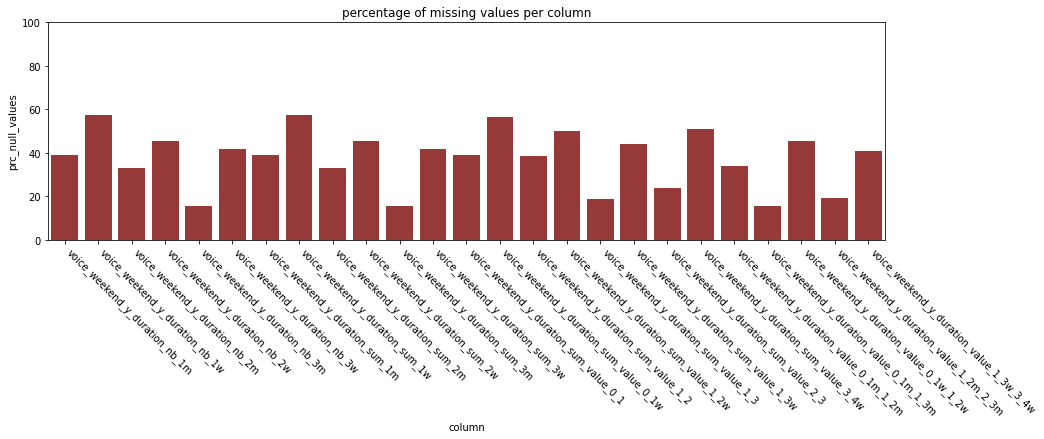

Column family voice_workingh_n_duration>


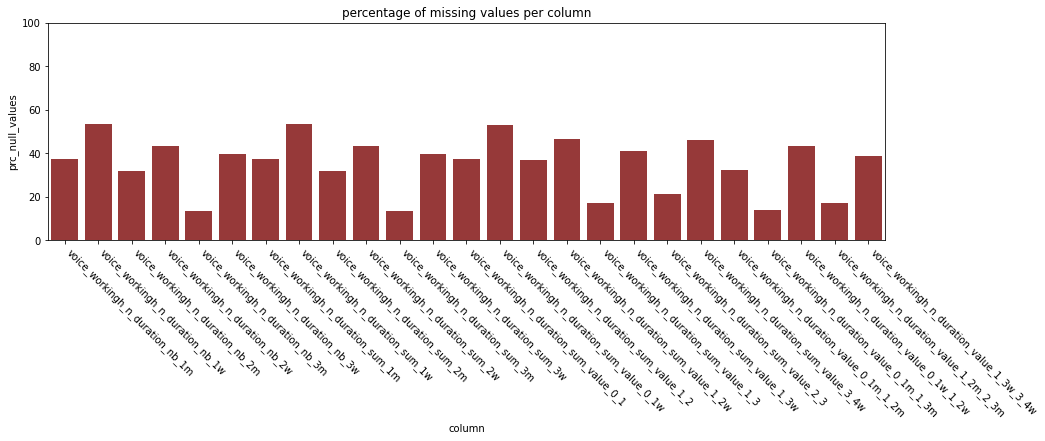

Column family voice_workingh_y_duration>


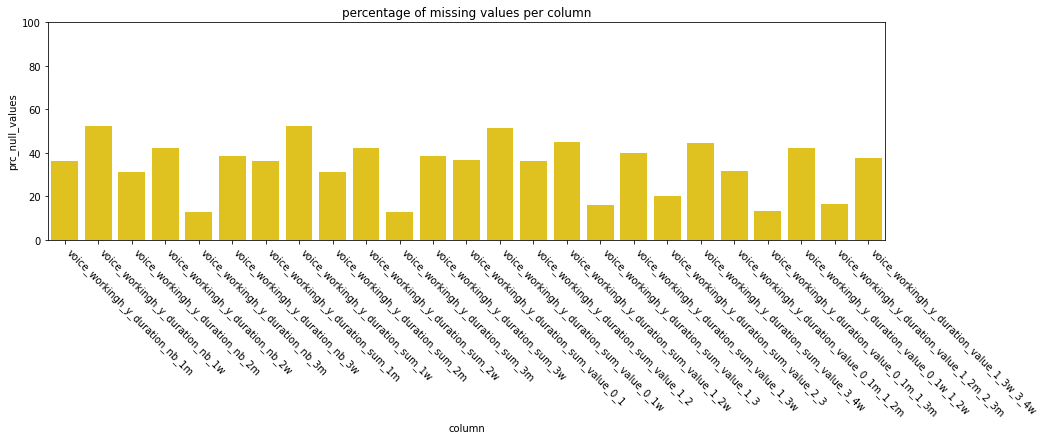

In [172]:
#Visualise missing values family by family
for key, value in columns_families.items():
    print (f"Column family {key}>")
    family = columns_families
    #Visualisation
    utils.vis_perc_missing_values_per_column(df_train[value])

In [173]:
#Columns that contains only 0 value
only_0_value_columns = [column for column in df_train.columns if not any(df_train[column]) ]
print ("the columns bellow contains only 0 value")
only_0_value_columns

the columns bellow contains only 0 value


[]

In [174]:
#Only 0 value columns should be deleted
"""df = df[[column for column in df.columns if column not in only_0_value_columns]]
print ("new list of columns after deleting only 0 value columns")
print (df.columns)"""

'df = df[[column for column in df.columns if column not in only_0_value_columns]]\nprint ("new list of columns after deleting only 0 value columns")\nprint (df.columns)'

**Percentages of missing values in dev and test data will be similar to those of train data because of the random sampling before spliting the data**

#### Heatmap of missing values 

In [175]:
#Missing values matrix
half = len(df_train.columns)//2
missing_values_matrix_1 = df_train[df_train.columns[0:half]].isna()
missing_values_matrix_2 = df_train[df_train.columns[half:]].isna()

Missing values in white, other values in black


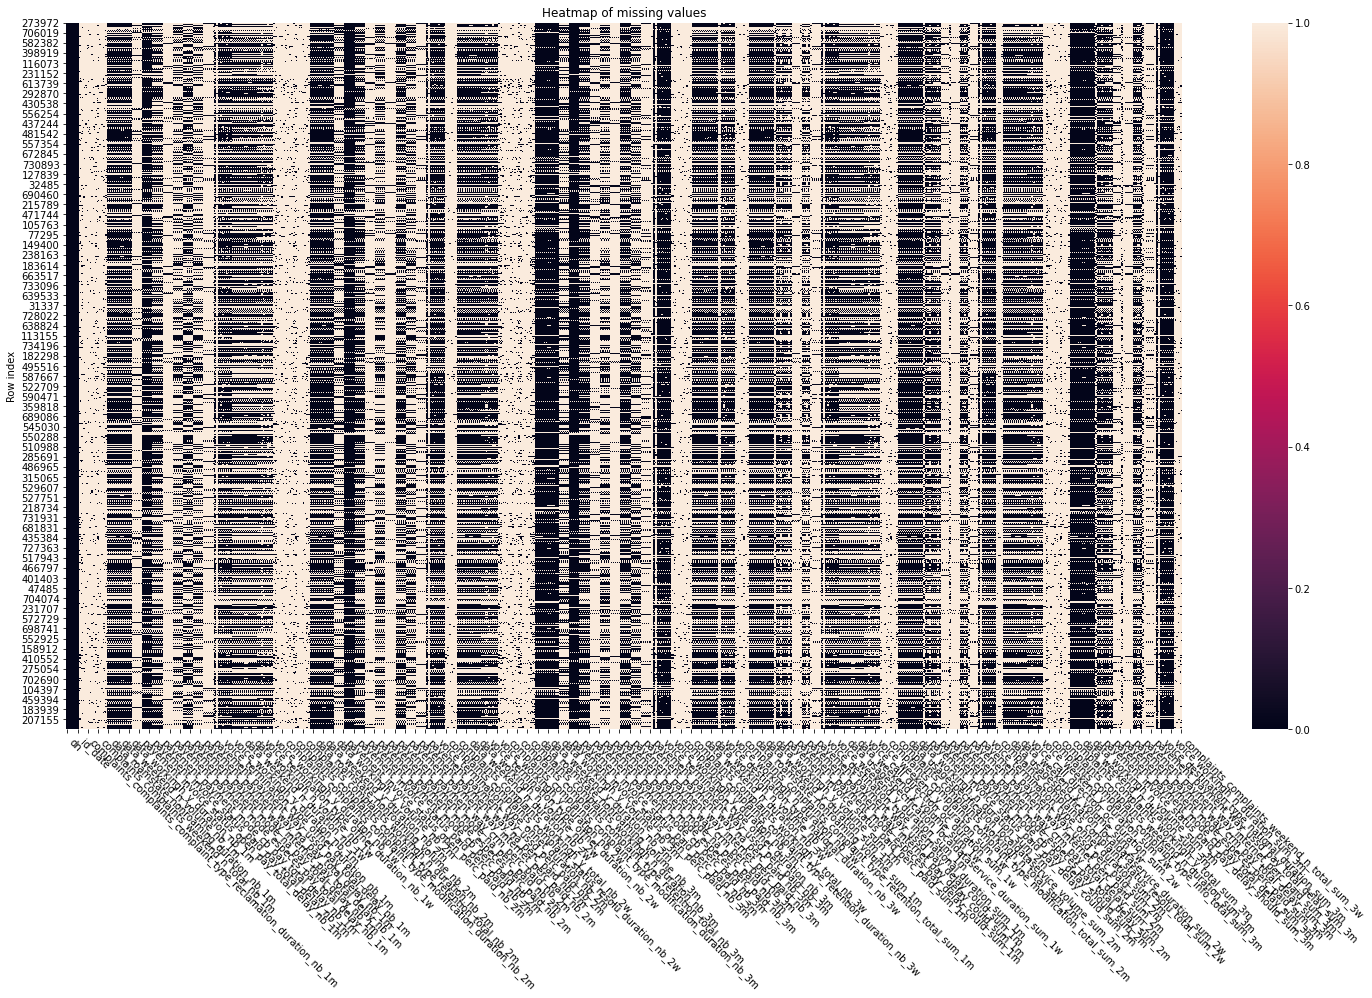

Missing values in white, other values in black


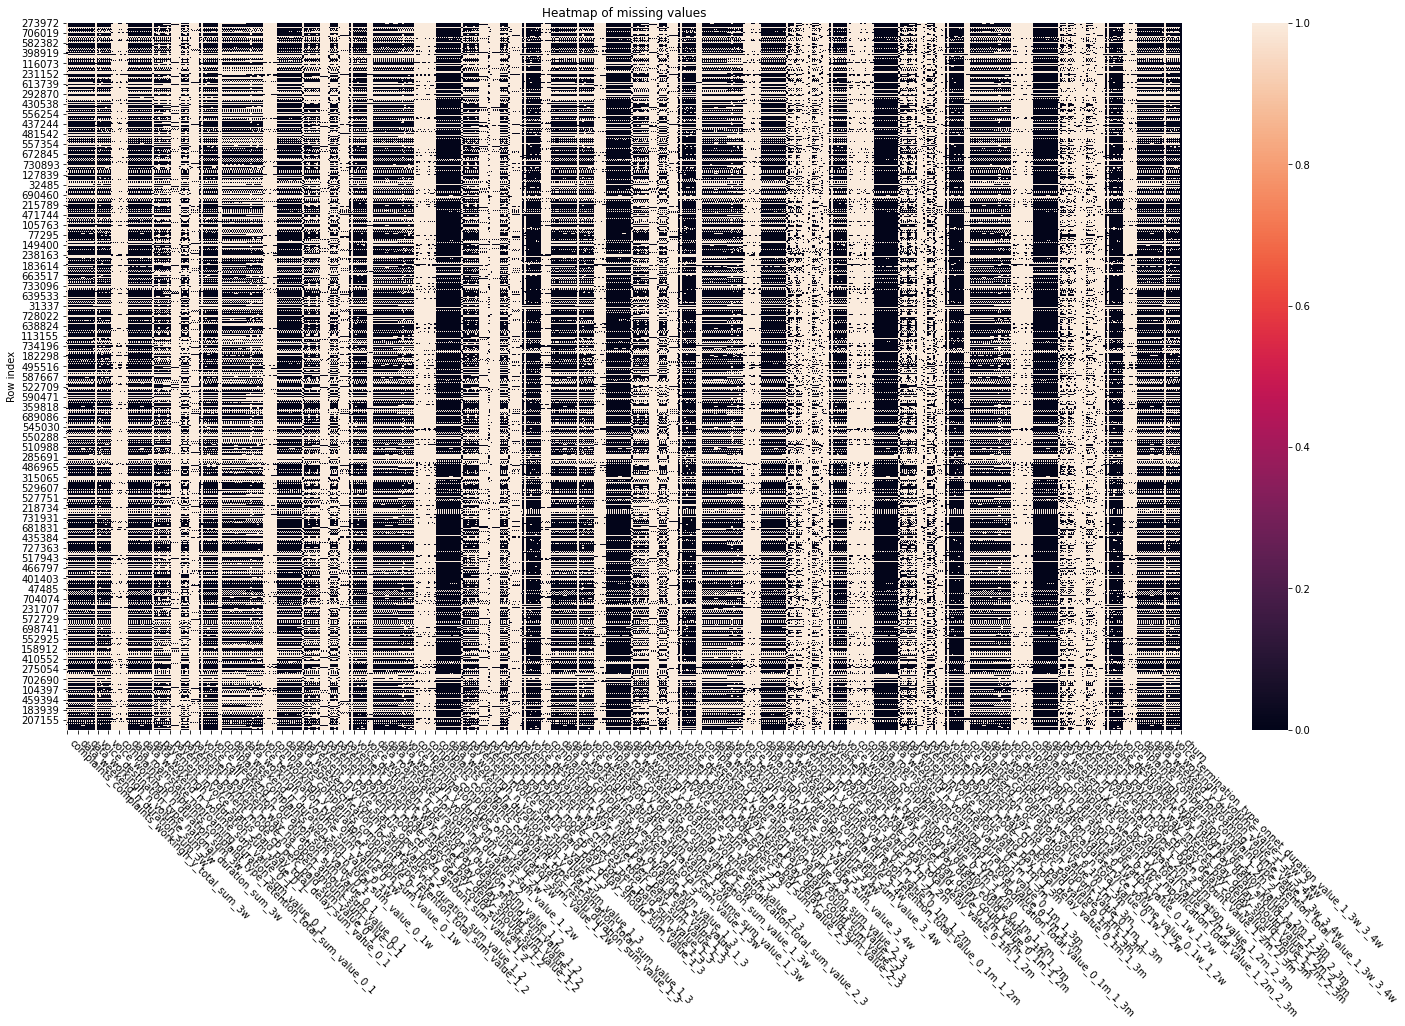

In [176]:
#Heatmap of missing values
utils.vis_missing_values_heatmap(missing_values_matrix_1)
utils.vis_missing_values_heatmap(missing_values_matrix_2)

#### Fill all missing values with 0

**df_train**

In [177]:
print (f"Total number of missing values in df : {df_train.isna().sum().sum()}")
df_train = df_train.fillna(0)
print (f"Total number of missing values in df_train after filling all nan with 0 : {df_train.isna().sum().sum()}")

Total number of missing values in df : 54348638
Total number of missing values in df_train after filling all nan with 0 : 0


**df_dev**

In [178]:
print (f"Total number of missing values in df : {df_dev.isna().sum().sum()}")
df_dev = df_dev.fillna(0)
print (f"Total number of missing values in df_dev after filling all nan with 0 : {df_dev.isna().sum().sum()}")

Total number of missing values in df : 9094442
Total number of missing values in df_dev after filling all nan with 0 : 0


**df_test**

In [179]:
print (f"Total number of missing values in df : {df_test.isna().sum().sum()}")
df_test = df_test.fillna(0)
print (f"Total number of missing values in df_test after filling all nan with 0 : {df_test.isna().sum().sum()}")

Total number of missing values in df : 3634536
Total number of missing values in df_test after filling all nan with 0 : 0


### Save final data 

In [180]:
#Save train dev test sets
df_train.to_csv(f"{data_path}/{date_time}_df_train_fillna_0.csv", index=True)
df_dev.to_csv(f"{data_path}/{date_time}_df_dev_fillna_0.csv", index=True)
df_test.to_csv(f"{data_path}/{date_time}_df_test_fillna_0.csv", index=True)